# Uma Análise de Dados Sobre O Sistema Único de Saúde (SUS) Brasileiro

![](https://raw.githubusercontent.com/diascarolina/healthcare-analysis/main/other/banner.png?token=AH6WME6YO5QSXJPZKTOZKWDAXL5HG)

# 1 Introdução

O Sistema Único de Saúde (SUS) brasileiro é o maior sistema de saúde pública, universal, descentralizado e igualitário gerenciado por um governo no mundo.<a href="https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(19)31243-7/fulltext#articleInformation">[1]</a> Criado para garantir o direito universal à saúde, presente na Constituição de 1988, o SUS tem como objetivos principais regulamentar, supervisionar, garantir e fornecer todo um aparato relacionado à saúde pública no Brasil, incluíndo não só procedimentos hospitalares, mas também atividades como controle e fiscalização de água e alimentos, e desenvolvimento científico.[[2]](http://www.planalto.gov.br/ccivil_03/leis/l8080.htm)

Na atual pandemia do Covid-19, o SUS vem sofrendo de uma crise gerada por superlotação de leitos e falta de investimentos do Governo Federal.[[3]](https://www.ceen.com.br/os-6-maiores-desafios-que-a-saude-publica-do-brasil-vem-enfrentando/) Essas dificuldades só escancaram ainda mais a importância de um país continental como o Brasil possuir um Sistema Único de Saúde de qualidade, que atinja todas as regiões igualmente.

É nesse contexto que faremos nossa análise de dados, tentando entender como o número de internações e o total de gastos estão relacionados. Partimos de uma análise mais geral e chegamos em uma análise mais específica, iniciando pelo contexto do país inteiro, depois dividindo por regiões e finalmente analisando um só Estado. Para isso, foi escolhida a Região Nordeste do Brasil e o Estado do Ceará para receberem um estudo mais aprofundado.

# 2 Descrição dos Dados

O SUS possui um sistema próprio de informática para processar e manter dados e informações sobre diversos indicadores de saúde e informações financeiras, o [DATASUS](https://datasus.saude.gov.br/).

No DATASUS temos o sistema [TABNET](http://www2.datasus.gov.br/DATASUS/index.php?area=02), que tem como finalidade permitir às equipes técnicas do Ministério da Saúde, das Secretarias Estaduais de Saúde e das Secretarias Municipais de Saúde a realização de tabulações rápidas sobre os dados presentes nos Sistemas de Informações do Sistema Único de Saúde.[[4]](http://www2.datasus.gov.br/DATASUS/index.php?area=060804)

Com isso em mente, vamos à parte técnica dos dados utilizados.

**Caminho dos Dados:** [TABNET](http://www2.datasus.gov.br/DATASUS/index.php?area=02) ➔ [Assistência à Saúde](http://www2.datasus.gov.br/DATASUS/index.php?area=0202) ➔ [Produção Hospitalar (SIH/SUS)](http://www2.datasus.gov.br/DATASUS/index.php?area=0202&id=11633) ➔ [Dados Consolidados AIH (RD), por local de internação, a partir de 2008](http://www2.datasus.gov.br/DATASUS/index.php?area=0202&id=11633&VObj=http://tabnet.datasus.gov.br/cgi/deftohtm.exe?sih/cnv/qi) ➔ [Abrangência Geográfica: Brasil por Região e Unidade da Federação](http://tabnet.datasus.gov.br/cgi/deftohtm.exe?sih/cnv/qiuf.def)

Nesta última página foram feitas as seleções:
- **Linha:** Unidade da Federação;
- **Coluna:** Ano/mês atendimento;
- **Conteúdo:** Internações e, em outra procura, valor total;
- **Períodos Disponíveis:** Jan/2008 a Mar/2021;
- **Seleções Disponíveis**: todas com os valores padrão.

Para os munícipios, foi selecionado o Estado do Ceará na área de _Abrangência Geográfica_ e o processo foi basicamente o mesmo.

**Data de Acesso:** 26/05/2021.

Na mesma página encontramos um documento com as [Notas Técnicas](http://tabnet.datasus.gov.br/cgi/sih/Proced_hosp_loc_int_2008.pdf) que nos fornece a **origem dos dados** e a **descrição das variáveis disponíveis para tabulação**. Desse modo, para as variáveis que utilizamos, temos que:

Dado | Descrição
:---|:---
**Internações** | Quantidade de AIH* aprovadas no período, não considerando as de prorrogação (longa permanência). Este é um valor aproximado das internações, pois as transferências e reinternações estão aqui computadas.
**Valor Total** | Valor referente às AIH aprovadas no período. Este valor não obrigatoriamente corresponde ao valor repassado ao estabelecimento, pois, dependendo da situação das unidades, estes recebem recursos orçamentários ou pode haver retenções e pagamentos de incentivos, não aqui apresentados. Portanto, este valor deve ser considerado como o valor aprovado da produção.
**Valor médio Int** | Valor Total dividido pela quantidade de Internações.

(\*) AIH - Autorização de Internação Hospitalar

# 3 Importação de Bibliotecas & Configurações

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import locale
from datetime import datetime

In [2]:
# formatar os números para mostrarem duas casa decimais
pd.options.display.float_format = '{:.2f}'.format

# mudar o idioma para convertermos as colunas para data
locale.setlocale(locale.LC_ALL , 'pt_BR.UTF-8')

# configurações de cores
GRAY1, GRAY2, GRAY3 = '#231F20', '#414040', '#555655'
GRAY4, GRAY5, GRAY6 = '#646369', '#76787B', '#828282'
GRAY7, GRAY8, GRAY9 = '#929497', '#A6A6A5', '#BFBEBE'
BLUE1, BLUE2, BLUE3, BLUE4 = '#174A7E', '#4A81BF', '#94B2D7', '#94AFC5'
RED1, RED2 = '#C3514E', '#E6BAB7'
GREEN1, GREEN2 = '#0C8040', '#9ABB59'
ORANGE1 = '#F79747'

# configurações da fonte utilizada nos gráficos
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.bf'] = 'Arial:bold'
plt.rcParams['mathtext.it'] = 'Arial:italic'

# 4 Número de Internações - Brasil

Como vimos nas [Notas Técnicas](http://tabnet.datasus.gov.br/cgi/sih/Proced_hosp_loc_int_2008.pdf), essa variável representa a
> Quantidade de Autorização de Internação Hospitalar (AIH) aprovadas no período, não considerando as de prorrogação (longa permanência). Este é um valor aproximado das internações, pois as transferências e reinternações estão aqui computadas.

Vamos analisar esse dataset inicialmente.

## 4.1 Carregamento & Limpeza dos Dados

Para cada arquivo _.csv_ utilizado, precisaremos saber o número de linhas do cabeçalho e rodapé para podermos configurar o carregamento de acordo. Para isso, podemos abrir cada arquivo _.csv_ em um leitor de texto qualquer para termos uma noção de qual valor utilizar nos parâmetros ```skiprows``` e ```skipfooter``` da função ```read_csv``` da biblioteca ```Pandas```. Mas nem sempre isso é possível de ser feito, em situações do dia-a-dia. Ainda bem que aqui sim!

In [3]:
# importar o aquivo do número das internações no Brasil
internacoes = pd.read_csv('../data/internacoes_brasil.csv', sep = ';', encoding = 'ISO-8859-1', skiprows = 3,
                            skipfooter = 12, thousands = '.', decimal = ',', engine = 'python')

In [4]:
internacoes.head(3)

,Unidade da Federação,2007/Jan,2007/Fev,2007/Mar,2007/Abr,2007/Mai,2007/Jun,2007/Jul,2007/Ago,2007/Set,...,2020/Jul,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar,Total
0,11 Rondônia,-,1,-,-,-,-,-,7,42,...,8376,8848,8379,8791,8865,8362,7221,4779,2106,1387140
1,12 Acre,1,-,-,-,-,1,-,5,17,...,3549,3574,3724,3973,3834,3821,3588,2898,1788,637069
2,13 Amazonas,3,2,-,1,-,-,1,59,69,...,15417,15709,15727,15796,15424,16213,16344,10777,6256,2248754


In [5]:
internacoes.tail(3)

,Unidade da Federação,2007/Jan,2007/Fev,2007/Mar,2007/Abr,2007/Mai,2007/Jun,2007/Jul,2007/Ago,2007/Set,...,2020/Jul,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar,Total
24,51 Mato Grosso,3,2,-,-,-,1,6,102,320,...,13666,13922,14257,14568,13946,13228,12207,10189,6787,2421359
25,52 Goiás,3,3,-,-,-,3,7,298,812,...,25576,25837,26288,26792,24894,23756,22425,18442,12400,4532259
26,53 Distrito Federal,4,12,1,-,1,1,9,47,281,...,16931,17705,17613,18395,17250,17473,17498,14852,11179,2559110


In [6]:
print('O dataframe \'internacoes\' possui {} linhas e {} colunas.'.format(internacoes.shape[0], internacoes.shape[1]))

O dataframe 'internacoes' possui 27 linhas e 173 colunas.


Como podemos ver acima, logo de cara, existem muitos valores faltantes no início do dataframe, pois os dados foram coletados a partir de 2008, e as colunas anteriores são valores adicionados retroativamente.

Vamos então remover as colunas que se encontram antes de Janeiro de 2008. Para isso vamos encontrar a localização dessa coluna para fazermos um slice.

In [7]:
print('A posição da coluna \'2008/Jan\' é a {}.'.format(internacoes.columns.get_loc('2008/Jan')))

A posição da coluna '2008/Jan' é a 13.


Vamos então remover as colunas antes da posição 13.

In [8]:
# cópia do dataframe original
interns = internacoes.copy()

# colocando a UF como indíce
interns = interns.set_index('Unidade da Federação').rename_axis(None)

# removendo as colunas (até a 12, pois tiramos uma coluna, a da UF)
interns = interns.drop(interns.columns[:12], axis = 1)

In [9]:
interns.head(3)

,2008/Jan,2008/Fev,2008/Mar,2008/Abr,2008/Mai,2008/Jun,2008/Jul,2008/Ago,2008/Set,2008/Out,...,2020/Jul,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar,Total
11 Rondônia,5242,5562,5105,5175,5148,6099,7080,7332,6875,6907,...,8376,8848,8379,8791,8865,8362,7221,4779,2106,1387140
12 Acre,3735,3723,4163,4223,4471,4478,4083,3823,4182,4141,...,3549,3574,3724,3973,3834,3821,3588,2898,1788,637069
13 Amazonas,13628,13828,14869,14323,14904,14578,14936,14413,13346,12602,...,15417,15709,15727,15796,15424,16213,16344,10777,6256,2248754


Agora vamos conferir se temos algum outro valor faltante.

In [10]:
print('Agora o dataframe \'aih\' possui {} linhas e {} colunas.'.format(interns.shape[0], interns.shape[1]))

Agora o dataframe 'aih' possui 27 linhas e 160 colunas.


In [11]:
interns.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27 entries, 11 Rondônia to 53 Distrito Federal
Columns: 160 entries, 2008/Jan to Total
dtypes: int64(160)
memory usage: 34.0+ KB


Utilizando o método ```.info()``` acima vemos que todas as 160 colunas são do tipo ```int64```, então não temos nenhum valor como "-" ou "...", pois, caso tivéssemos, a coluna seria, provavelmente, do tipo ```object```. 

Também percebemos que os Estados estão ordenados por Regiões. Com isso, fica fácil fazer um slice nos dados.

In [12]:
# separar por regiões
norte = interns.index[:7].tolist()
nordeste = interns.index[7:16].tolist()
sudeste = interns.index[16:20].tolist()
sul = interns.index[20:23].tolist()
centro_oeste = interns.index[23:].tolist()

In [13]:
# criar um novo dataset para facilitar a plotagem dos dados
internas = interns.copy()
internas = internas.sort_values(by = 'Total', ascending = False)
internas = internas.drop('Total', axis = 1)
internas.columns = pd.to_datetime(internas.columns, format='%Y/%b')

## 4.2 Análise Gráfica

Podemos enxergar melhor os valores de cada região através de gráficos. Vamos analisar graficamente o número de internações de cada região do país.

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


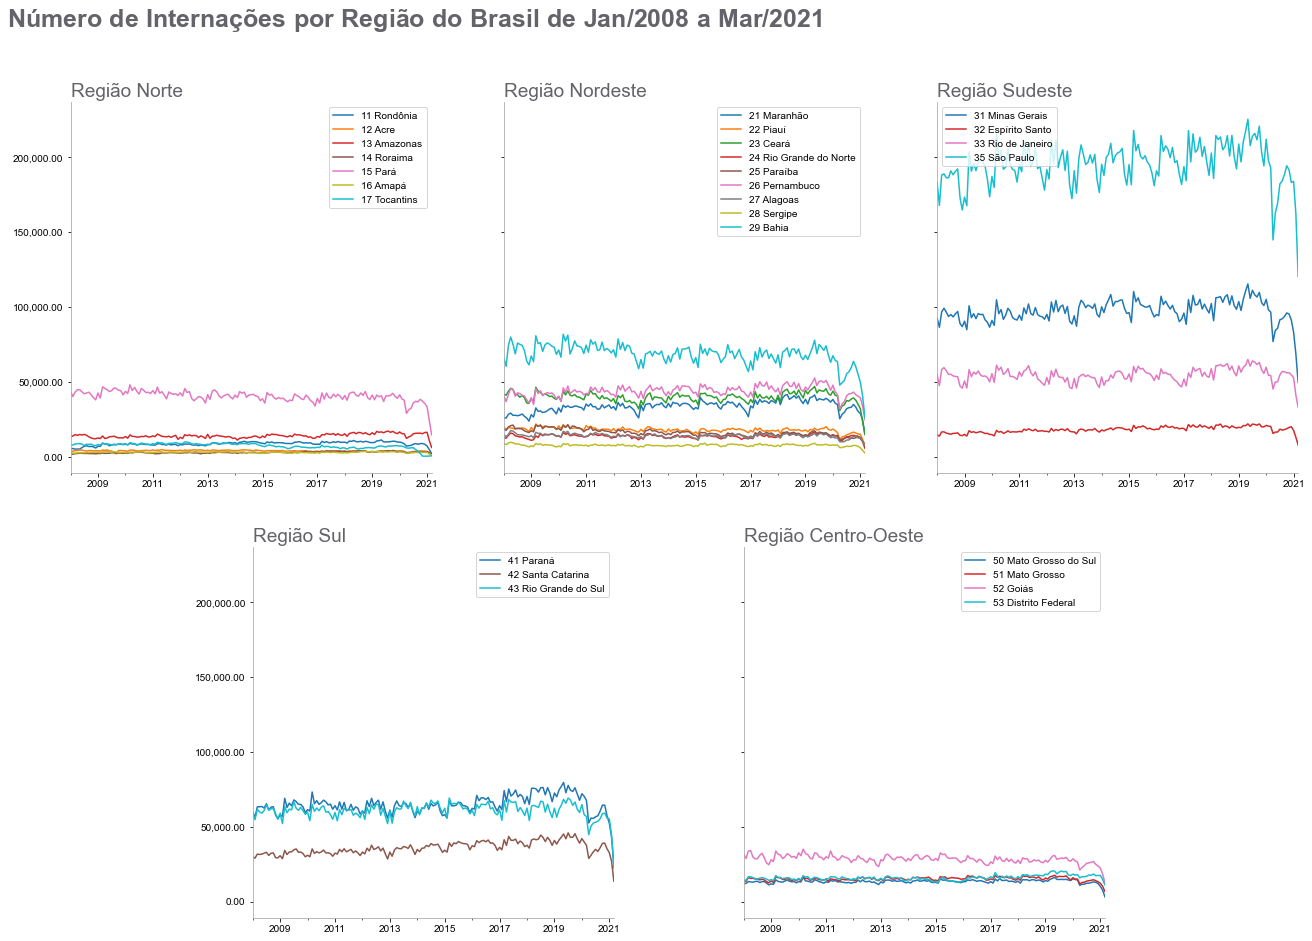

In [14]:
fig, axes = plt.subplots(2, 3, sharey = True, figsize = (22, 15))

fig.text(0.085, 0.95, '$\\bf{Número\ de\ Internações\ por\ Região\ do\ Brasil\ de\ Jan/2008\ a\ Mar/2021}$',
         fontsize = 25, color = GRAY4)

axes[1, 2].set_visible(False)

internas.loc[norte].T.plot(ax = axes[0, 0], colormap = 'tab10')
axes[0, 0].set_title('Região Norte', loc = 'left', fontsize = 19, color = GRAY4)
axes[0, 0].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
axes[0, 0].spines['bottom'].set_color('darkgrey')
axes[0, 0].spines['left'].set_color('darkgrey')
axes[0, 0].spines['right'].set_visible(False)
axes[0, 0].spines['top'].set_visible(False)

internas.loc[nordeste].T.plot(ax = axes[0, 1], colormap = 'tab10')
axes[0, 1].set_title('Região Nordeste', loc = 'left', fontsize = 19, color = GRAY4)
axes[0, 1].spines['bottom'].set_color('darkgrey')
axes[0, 1].spines['left'].set_color('darkgrey')
axes[0, 1].spines['right'].set_visible(False)
axes[0, 1].spines['top'].set_visible(False)

internas.loc[sudeste].T.plot(ax = axes[0, 2], colormap = 'tab10')
axes[0, 2].set_title('Região Sudeste', loc = 'left', fontsize = 19, color = GRAY4)
axes[0, 2].spines['bottom'].set_color('darkgrey')
axes[0, 2].spines['left'].set_color('darkgrey')
axes[0, 2].spines['right'].set_visible(False)
axes[0, 2].spines['top'].set_visible(False)

internas.loc[sul].T.plot(ax = axes[1, 0], colormap = 'tab10')
axes[1, 0].set_title('Região Sul', loc = 'left', fontsize = 19, color = GRAY4)
axes[1, 0].spines['bottom'].set_color('darkgrey')
axes[1, 0].spines['left'].set_color('darkgrey')
axes[1, 0].spines['right'].set_visible(False)
axes[1, 0].spines['top'].set_visible(False)

internas.loc[centro_oeste].T.plot(ax = axes[1, 1], colormap = 'tab10')
axes[1, 1].set_title('Região Centro-Oeste', loc = 'left', fontsize = 19, color = GRAY4)
axes[1, 1].spines['bottom'].set_color('darkgrey')
axes[1, 1].spines['left'].set_color('darkgrey')
axes[1, 1].spines['right'].set_visible(False)
axes[1, 1].spines['top'].set_visible(False)

axes[1, 0].set_position([0.24, 0.125, 0.228, 0.343])
axes[1, 1].set_position([0.55, 0.125, 0.228, 0.343])

#plt.savefig('1.jpg')

plt.show()

Com todos os gráficos compartilhando o mesmo eixo x e y, a comparação é imediata e aparentemente está tudo certo com os valores, não temos nada muito distante dos demais. Como essa é uma visualização mais geral, não há tanto problema com o fato de alguns estados estarem pouco visíveis. Queremos exergar mais uma visão geral do que o detalhe em si. Faremos isso mais a frente.

Algumas observações que tiramos desse gráfico:
- Há uma sazonalidade no número de internações
    - Iremos observar melhor a seguir em quais períodos as altas e baixas acontecem
- Embora exista uma tendência de queda, ela é muito pouca e há uma certa estabilidade nos valores
- Há uma queda de internações nos últimos meses?
    - Essa queda que existe no final do gráfico deve-se ao fato do ano ainda não estar terminado, então os valores ainda não estão todos colocados para esse período. Podemos remover esses valores ou deixar como está. Optei por deixar do jeito que está.

**Em qual posição do Brasil o Estado do Ceará se encontra no número de internações?**

In [15]:
# o dataset "internas" já está ordenado pelo valor total (somamos 1 pois a contagem se inicia no 0)
print('A posição do Ceará no número de internações no Brasil é: {}.'.format(internas.index.get_loc('23 Ceará') + 1))

A posição do Ceará no número de internações no Brasil é: 9.


In [16]:
internacoes_ord = internas.copy()
internacoes_ord['Total'] = internacoes_ord.sum(axis = 1)
internacoes_ord = internacoes_ord['Total']

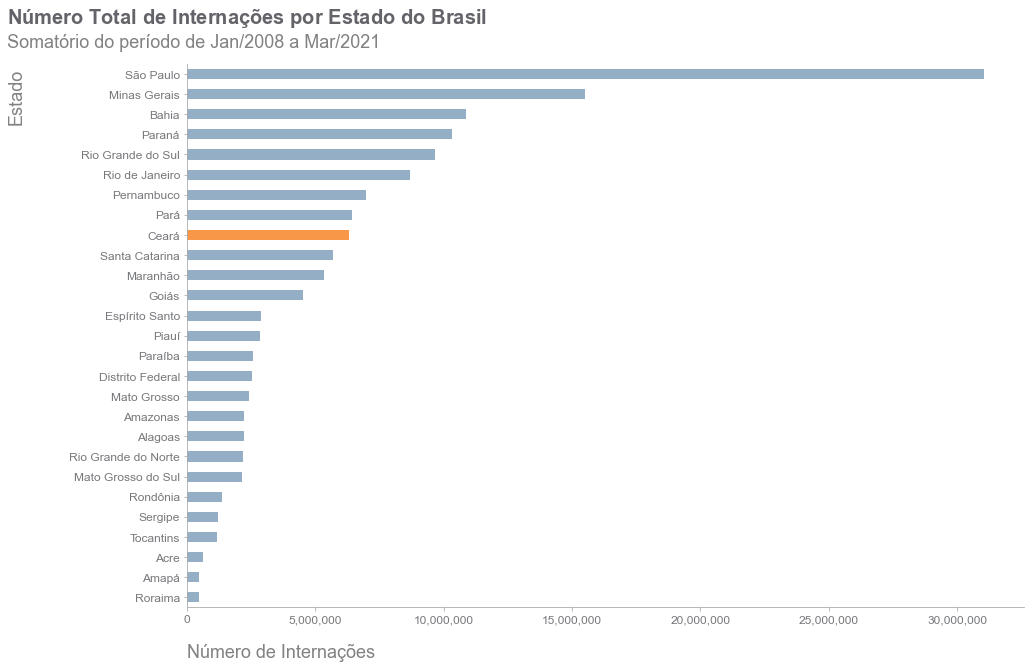

In [17]:
cores = []
for value in internacoes_ord.keys():
    if '23 Ceará' == value:
        cores.append(ORANGE1)
    else:
        cores.append(BLUE4)
cores.reverse()

ax = internacoes_ord.sort_values(ascending = True).plot(kind = 'barh', figsize = (15, 10), color = cores)

ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.tick_params(color = 'darkgrey', bottom = 'off')
ax.spines['bottom'].set_color('darkgrey')
ax.spines['left'].set_color('darkgrey')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(12)
    i.set_color(GRAY5)
    
# remover o número do nome dos Estados
ax.set_yticklabels([k[3:] for k in internacoes_ord.index.to_list()[::-1]])
    
plt.text(-7000000, 28.5, '$\\bf{Número\ Total\ de\ Internações\ por\ Estado\ do\ Brasil}$',
         fontsize = 20, color = GRAY4)
plt.text(-7000000, 27.3, 'Somatório do período de Jan/2008 a Mar/2021',
         fontsize = 18, color = GRAY6)

plt.text(-7000000, 23.7, 'Estado', fontsize = 18, rotation = 'vertical', color = GRAY6)
plt.text(455, -3, 'Número de Internações', fontsize = 18, color = GRAY6)

plt.show()

In [18]:
internas_total = internas.copy()
internas_total['Soma'] = internas_total.sum(axis = 1)
internas_total['Porcentagem'] = (internas_total['Soma'] / internas_total['Soma'].sum()) * 100

In [19]:
print('A quantidade de internações no Ceará corresponde a {:.2f}% do total do Brasil, \
       \nou seja, {} internações no período de Jan/2008 a  Mar/2021.'.format(internas_total['Porcentagem']['23 Ceará'], internas_total['Soma']['23 Ceará']))

A quantidade de internações no Ceará corresponde a 4.25% do total do Brasil,        
ou seja, 6322342 internações no período de Jan/2008 a  Mar/2021.


In [20]:
# outro dataframe para auxiliar na plotagem
internas = internas.T

In [21]:
internas['Nordeste'] = internas[nordeste].sum(axis = 1)
internas['Norte'] = internas[norte].sum(axis = 1)
internas['Sudeste'] = internas[sudeste].sum(axis = 1)
internas['Sul'] = internas[sul].sum(axis = 1)
internas['Centro_Oeste'] = internas[centro_oeste].sum(axis = 1)

internas = internas[['Nordeste', 'Norte', 'Sudeste', 'Sul', 'Centro_Oeste']]

internas.head()

,Nordeste,Norte,Sudeste,Sul,Centro_Oeste
2008-01-01,249736,79335,345600,148883,72260
2008-02-01,234262,75434,315847,140037,68557
2008-03-01,266151,80410,359802,156629,79740
2008-04-01,283801,82122,364509,154753,79269
2008-05-01,274964,83323,356554,154358,74318


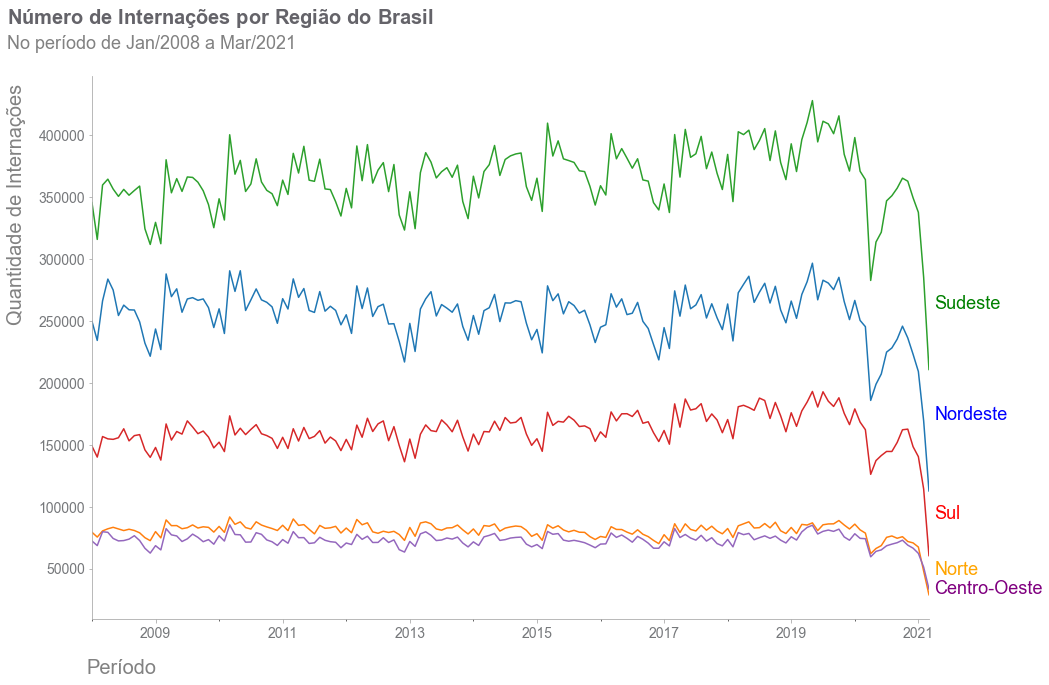

In [22]:
ax = internas.plot(figsize = (15, 10))

ax.tick_params(color = 'darkgrey', bottom = 'off')
ax.spines['bottom'].set_color('darkgrey')
ax.spines['left'].set_color('darkgrey')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(14)
    i.set_color(GRAY5)


plt.text(440, 490000, '$\\bf{Número\ de\ Internações\ por\ Região\ do\ Brasil}$',
         fontsize = 20, color = GRAY4)
plt.text(440, 470000, 'No período de Jan/2008 a Mar/2021',
         fontsize = 18, color = GRAY6)

plt.text(440, 250000, 'Quantidade de Internações', fontsize = 20, rotation = 'vertical', color = GRAY6)
plt.text(455, -35000, 'Período', fontsize = 20, color = GRAY6)

plt.text(615, 260000, 'Sudeste', fontsize = 18, color = 'green')
plt.text(615, 170000, 'Nordeste', fontsize = 18, color = 'blue')
plt.text(615, 90000, 'Sul', fontsize = 18, color = 'red')
plt.text(615, 45000, 'Norte', fontsize = 18, color = 'orange')
plt.text(615, 30000, 'Centro-Oeste', fontsize = 18, color = 'purple')

ax.get_legend().remove()

plt.show()

Graficamente já fica evidente que o Nordeste é a segunda região do país com a maior quantidade de internações no período analisado.

In [23]:
internas = internas.T

In [24]:
internas['Soma'] = internas.sum(axis = 1)
internas['Porcentagem'] = (internas['Soma'] / internas['Soma'].sum()) * 100
internas

,2008-01-01 00:00:00,2008-02-01 00:00:00,2008-03-01 00:00:00,2008-04-01 00:00:00,2008-05-01 00:00:00,2008-06-01 00:00:00,2008-07-01 00:00:00,2008-08-01 00:00:00,2008-09-01 00:00:00,2008-10-01 00:00:00,...,2020-08-01 00:00:00,2020-09-01 00:00:00,2020-10-01 00:00:00,2020-11-01 00:00:00,2020-12-01 00:00:00,2021-01-01 00:00:00,2021-02-01 00:00:00,2021-03-01 00:00:00,Soma,Porcentagem
Nordeste,249736,234262,266151,283801,274964,254389,262784,259008,258820,249257,...,228178,235284,245788,236280,223116,209180,169271,112705,40595291,27.29
Norte,79335,75434,80410,82122,83323,81990,80693,81766,80745,78874,...,76332,74475,75745,71856,70742,67387,47889,28833,12806923,8.61
Sudeste,345600,315847,359802,364509,356554,350610,356251,351552,355352,358931,...,351134,357234,365316,362872,349480,337705,285158,210757,58101446,39.06
Sul,148883,140037,156629,154753,154358,155674,162895,153145,157368,158185,...,144560,151863,162101,162610,148443,140389,114247,60457,25673670,17.26
Centro_Oeste,72260,68557,79740,79269,74318,72332,72603,73765,76527,72651,...,69731,70889,72909,68909,66493,62276,51154,33515,11589554,7.79


In [25]:
print('A Região Nordeste possui {:.2f}% do total de internações do país no período analisado.'.format(internas['Porcentagem']['Nordeste']))

A Região Nordeste possui 27.29% do total de internações do país no período analisado.


In [26]:
internacoes_nordeste = interns.loc[nordeste].sort_values(by = 'Total', ascending = False)
internacoes_nordeste = internacoes_nordeste.drop('Total', axis = 1)
internacoes_nordeste.columns = pd.to_datetime(internacoes_nordeste.columns, format='%Y/%b')

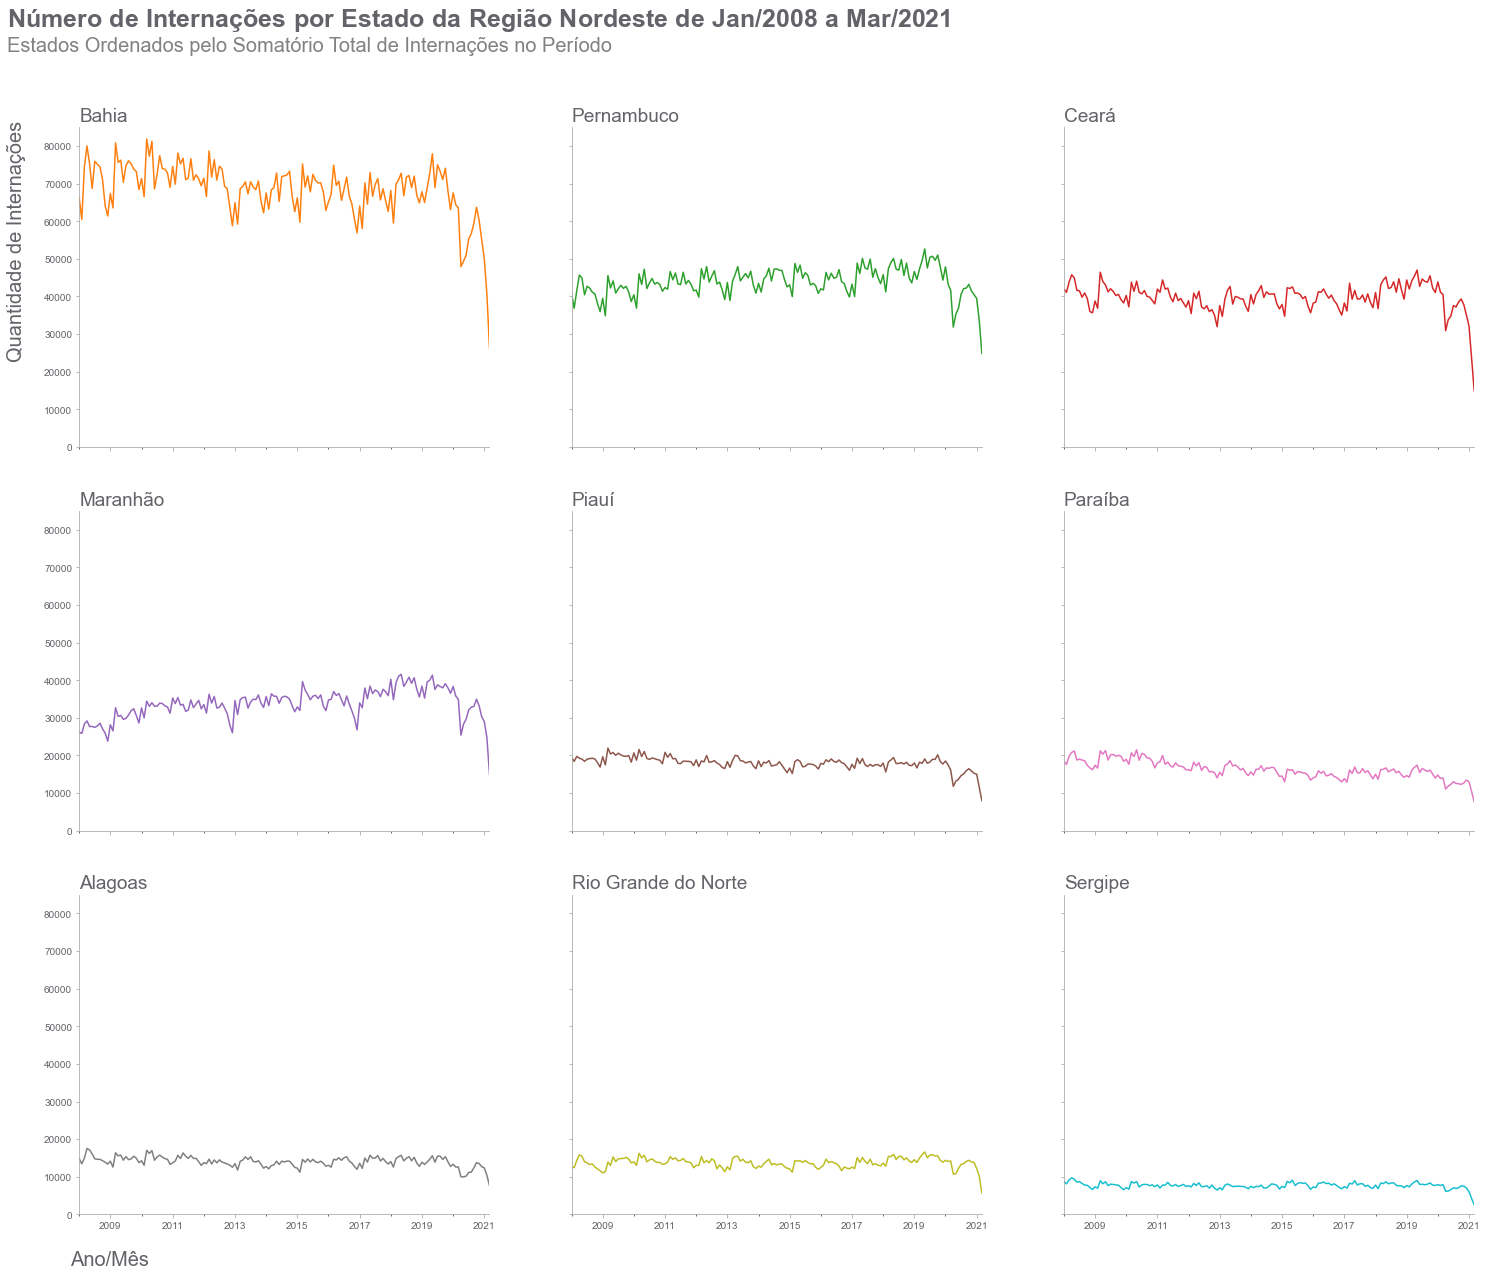

In [27]:
fig, axes = plt.subplots(3, 3, sharex = True, sharey = True, figsize = (25, 20))

palette = plt.get_cmap('tab10')

fig.text(0.085, 0.95, '$\\bf{Número\ de\ Internações\ por\ Estado\ da\ Região\ Nordeste\ de\ Jan/2008\ a\ Mar/2021}$',
         fontsize = 25, color = GRAY4)
fig.text(0.085, 0.933, 'Estados Ordenados pelo Somatório Total de Internações no Período',
         fontsize = 20, color = GRAY6)

fig.text(0.085, 0.72, 'Quantidade de Internações', fontsize = 20, rotation = 'vertical', color = GRAY4)
fig.text(0.12, 0.09, 'Ano/Mês', fontsize = 20, color = GRAY4)

num = 0

for estado in internacoes_nordeste.index.tolist():
    num += 1
    plt.subplot(3, 3, num)
    ax = internacoes_nordeste.loc[estado].T.plot(color = palette(num))
    plt.ylim(0,85000)
    if num in range(7) :
        plt.tick_params(labelbottom = False)
    if num not in [1,4,7] :
        plt.tick_params(labelleft = False)
    plt.title(estado[3:], loc = 'left', fontsize = 19, color = GRAY4)
    
    for i in ax.get_yticklabels() + ax.get_xticklabels():
        i.set_fontsize(10)
        i.set_color(GRAY4)
    
    ax.tick_params(color = 'darkgrey')
    ax.spines['bottom'].set_color('darkgrey')
    ax.spines['left'].set_color('darkgrey')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
plt.show()

Com isso, vemos que os três estados do Nordeste que mais tiveram internações de Janeiro de 2008 a Março de 2021 foram Bahia, Pernambuco e Ceará. A quantidade de internações manteve-se quase que estável, se não considerarmos o ano de 2021, pois os dados ainda não estão completos.

Analisando agora apenas o estado do Ceará.

In [28]:
# dataframe temporário
intern_nordeste = internacoes_nordeste.copy()
intern_nordeste['Soma'] = intern_nordeste.sum(axis = 1)
intern_nordeste['Porcentagem'] = (intern_nordeste['Soma'] / intern_nordeste['Soma'].sum()) * 100

In [29]:
print('O Estado do Ceará possui {:.2f}% das internações totais da Região Nordeste no período analisado.'.format(intern_nordeste['Porcentagem']['23 Ceará']))

O Estado do Ceará possui 15.57% das internações totais da Região Nordeste no período analisado.


In [30]:
internacoes_ceara = internacoes_nordeste.loc['23 Ceará']

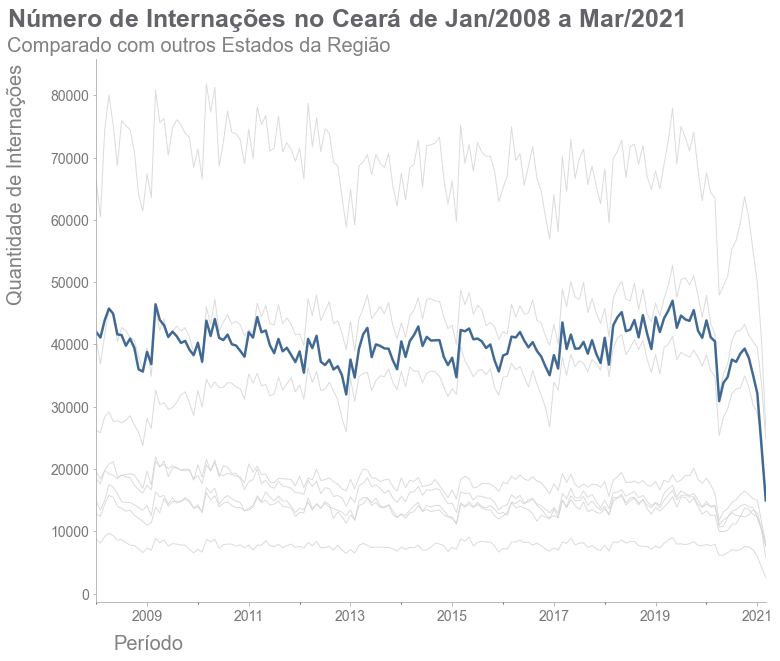

In [31]:
plt.figure(figsize = (12, 10))

for estado in internacoes_nordeste.index.tolist():
    ax = internacoes_nordeste.loc[estado].T.plot(color = 'lightgrey', linewidth = 1, alpha = 0.8)

ax = internacoes_nordeste.loc['23 Ceará'].T.plot(color = BLUE1, linewidth = 2.5, alpha = 0.8)

ax.tick_params(color = 'darkgrey')
ax.spines['bottom'].set_color('darkgrey')
ax.spines['left'].set_color('darkgrey')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(14)
    i.set_color(GRAY5)


plt.text(435, 90999, '$\\bf{Número\ de\ Internações\ no\ Ceará\ de\ Jan/2008\ a\ Mar/2021}$',
         fontsize = 25, color = GRAY4)
plt.text(435, 86999, 'Comparado com outros Estados da Região',
         fontsize = 20, color = GRAY6)

plt.text(435, 47000, 'Quantidade de Internações', fontsize = 20, rotation = 'vertical', color = GRAY6)
plt.text(460, -9000, 'Período', fontsize = 20, color = GRAY6)

plt.show()

Novamente não considerando os últimos meses por não estarem totalmente atualizados, percebemos que as internações mantém certa estabilidade ao passar dos anos, mas também notamos que existem períodos de alta e baixa, e uma sazonalidade.

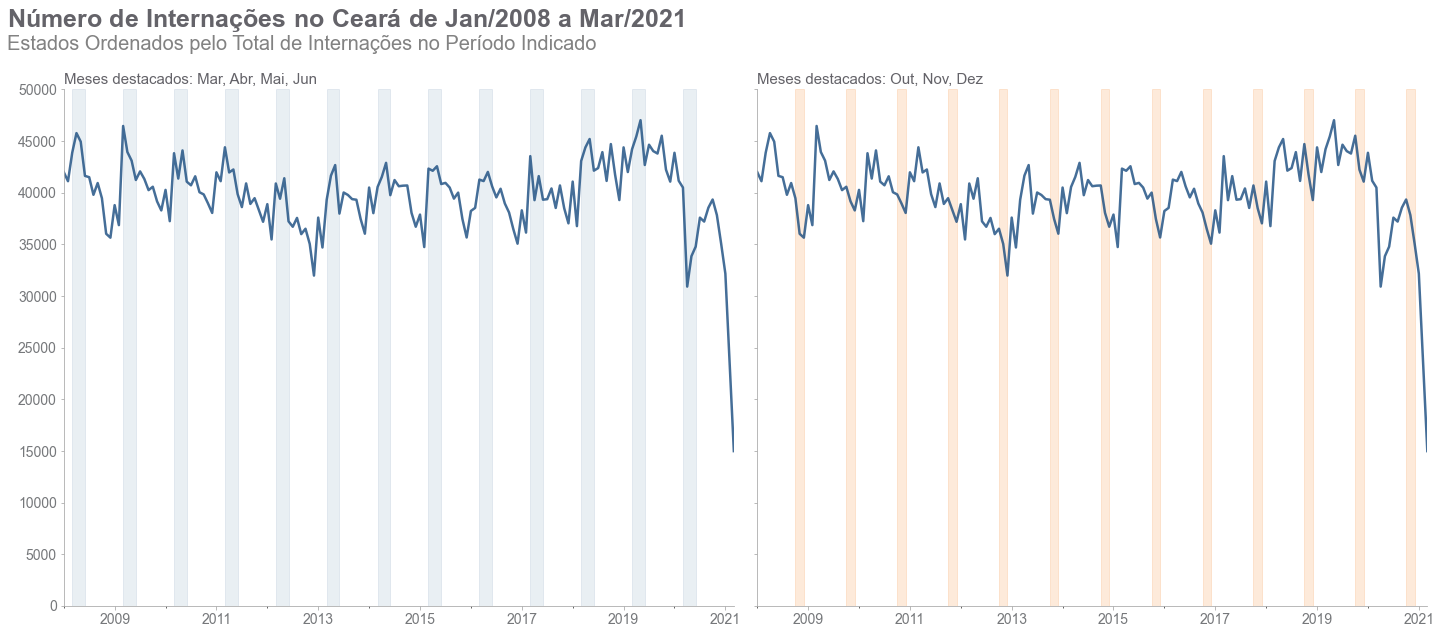

In [32]:
fig, axes = plt.subplots(1, 2, sharex = False, sharey = True, figsize = (20, 8))

fig.text(0, 1.06, '$\\bf{Número\ de\ Internações\ no\ Ceará\ de\ Jan/2008\ a\ Mar/2021}$',
         fontsize = 25, color = GRAY4)

fig.text(0, 1.02, 'Estados Ordenados pelo Total de Internações no Período Indicado',
         fontsize = 20, color = GRAY6)

internacoes_nordeste.loc['23 Ceará'].T.plot(ax = axes[0], color = BLUE1, linewidth = 2.5, alpha = 0.8)
internacoes_nordeste.loc['23 Ceará'].T.plot(ax = axes[1], color = BLUE1, linewidth = 2.5, alpha = 0.8)

plt.ylim(0, 50000)
axes[0].set_yticks(range(0, 50001, 5000))

for i in [0, 1]:
    axes[i].tick_params(color = 'darkgrey')
    axes[i].spines['bottom'].set_color('darkgrey')
    axes[i].spines['left'].set_color('darkgrey')
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['top'].set_visible(False)
    for k in axes[i].get_yticklabels() + axes[i].get_xticklabels():
        k.set_fontsize(14)
        k.set_color(GRAY5)

anos = []
for valor in range(2008, 2022):
    anos.append(valor)

for ano in range(len(anos)):
    axes[0].axvspan(datetime(anos[ano],3,1), datetime(anos[ano],6,1), color = BLUE4, alpha = 0.2)
    axes[1].axvspan(datetime(anos[ano],10,1), datetime(anos[ano],12,1), color = ORANGE1, alpha = 0.2)
    

axes[0].set_title('Meses destacados: Mar, Abr, Mai, Jun', loc = 'left', fontsize = 15, color = GRAY4)
axes[1].set_title('Meses destacados: Out, Nov, Dez', loc = 'left', fontsize = 15, color = GRAY4)

fig.tight_layout()
    
plt.show()

Novamente desconsiderando o período dos anos de 2020 e 2021 por estarem incompletos, observamos que as altas no número internações no Estado do Ceará ocorrem nos meses de Março a Junho. Já os períodos de baixa no número de internações ocorrem nos meses de Outubro a Janeiro, aproximadamente.

## 4.3 Conclusões

- O Ceará é o 9º Estado do Brasil com maior número de internações de Janeiro de 2008 a Março de 2021;
- A quantidade de internações no Ceará corresponde a 4.25% do total do Brasil, seja, 6322342 internações no período analisado;
- A Região Nordeste possui 27.29% das internações totais do país no período analisado;
- O Ceará é o 3º Estado da Região Nordeste em número de internações no período analisado;
- O Estado do Ceará possui 15.57% das internações totais da Região Nordeste no período analisado;
- Sobre a sazonalidade nos números de internações no Estado do Ceará: as altas ocorrem nos meses de Março a Junho, anualmente e os períodos de baixa ocorrem nos meses de Outubro a Janeiro anualmente, aproximadamente.

# 5 Número de Internações por Município do Ceará - Por Local de Internação

Vamos agora comparar o número de internações no Ceará, focando na capital Fortaleza, e a comparando com os demais municícpios do Estado.

Aqui vale uma ressalva:

Para analisar esse dado, existe a opção de contabilizar o município onde o paciente foi internado, ou o município onde o paciente reside. Esses dois casos nem sempre dão os mesmos valores, pois muitas vezes pessoas que residem em municípios menos favorecidos, internam-se na capital, pois é onde estão grande parte dos hospitais.

Faremos uma breve comparação desses dois casos para vermos se existe mesmo uma grande disparidade entre esses dados.

## 5.1 Carregamento e Limpeza dos Dados

In [33]:
# número de internações por município do Ceará por local de internação
intern_munic_local_raw = pd.read_csv('../data/intern_muni_ce_por_local_de_internacao.csv', sep = ';', encoding = 'ISO-8859-1', skiprows = 3,
                            skipfooter = 13, thousands = '.', decimal = ',', engine = 'python')

In [34]:
intern_munic_local_raw.head(3)

,Município,2007/Jan,2007/Fev,2007/Jul,2007/Ago,2007/Set,2007/Out,2007/Nov,2007/Dez,2008/Jan,...,2020/Jul,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar,Total
0,230020 Acaraú,-,-,-,-,-,-,2,22,218,...,223,182,247,254,337,344,312,-,-,48329
1,230030 Acopiara,-,-,-,2,-,2,4,12,329,...,99,219,159,221,148,77,97,112,109,25017
2,230040 Aiuaba,-,-,-,-,-,-,1,10,16,...,23,13,16,16,15,5,-,-,-,1733


Vamos limpar um pouco esses dados.

In [35]:
# cópia do dataframe original
intern_munic_local = intern_munic_local_raw.copy()

# remover os 6 números iniciais dos nomes dos municípios
intern_munic_local['Município'] = intern_munic_local['Município'].str[7:]

# coloca a coluna Município como índice
intern_munic_local = intern_munic_local.set_index('Município').rename_axis(None)

intern_munic_local.columns

Index(['2007/Jan', '2007/Fev', '2007/Jul', '2007/Ago', '2007/Set', '2007/Out',
       '2007/Nov', '2007/Dez', '2008/Jan', '2008/Fev',
       ...
       '2020/Jul', '2020/Ago', '2020/Set', '2020/Out', '2020/Nov', '2020/Dez',
       '2021/Jan', '2021/Fev', '2021/Mar', 'Total'],
      dtype='object', length=168)

Vemos que as 8 primeiras colunas correspondem ao ano de 2007. Vamos removê-las, pois começaremos nossas análises a partir de Janeiro de 2008.

In [36]:
intern_munic_local = intern_munic_local[intern_munic_local.columns[8:]]
intern_munic_local.head(3)

,2008/Jan,2008/Fev,2008/Mar,2008/Abr,2008/Mai,2008/Jun,2008/Jul,2008/Ago,2008/Set,2008/Out,...,2020/Jul,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar,Total
Acaraú,218,303,304,307,289,277,272,223,278,214,...,223,182,247,254,337,344,312,-,-,48329
Acopiara,329,378,320,277,268,254,228,284,241,228,...,99,219,159,221,148,77,97,112,109,25017
Aiuaba,16,13,15,8,8,7,13,13,14,10,...,23,13,16,16,15,5,-,-,-,1733


In [37]:
intern_munic_local.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172 entries, Acaraú to Viçosa do Ceará
Columns: 160 entries, 2008/Jan to Total
dtypes: int64(1), object(159)
memory usage: 216.3+ KB


Temos 159 colunas do tipo ```object``` e uma coluna do tipo ```int64```.

Já sabemos pelo TABNET que o hífen nos dados equivale a _"Dado numérico igual a 0 não resultante de arredondamento."_

Vamos então fazer a substituição.

In [38]:
intern_munic_local = intern_munic_local.replace('-', 0)

In [39]:
intern_munic_local.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172 entries, Acaraú to Viçosa do Ceará
Columns: 160 entries, 2008/Jan to Total
dtypes: int64(1), object(159)
memory usage: 216.3+ KB


Mesmo realizando a substituição por zero, as colunas continuaram como ```object```. Vamos forçá-las a virarem do tipo numérico.

In [40]:
intern_munic_local = intern_munic_local.apply(pd.to_numeric, errors = 'coerce')

In [41]:
intern_munic_local.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172 entries, Acaraú to Viçosa do Ceará
Columns: 160 entries, 2008/Jan to Total
dtypes: int64(160)
memory usage: 216.3+ KB


Agora sim, todas as nossas colunas estão como ```int64``` e podemos analisá-las.

In [42]:
intern_munic_local.columns

Index(['2008/Jan', '2008/Fev', '2008/Mar', '2008/Abr', '2008/Mai', '2008/Jun',
       '2008/Jul', '2008/Ago', '2008/Set', '2008/Out',
       ...
       '2020/Jul', '2020/Ago', '2020/Set', '2020/Out', '2020/Nov', '2020/Dez',
       '2021/Jan', '2021/Fev', '2021/Mar', 'Total'],
      dtype='object', length=160)

Temos uma coluna 'Total'. Vamos removê-la e, caso necessário, podemos somar novamente os valores para obtê-la.

In [43]:
intern_munic_local = intern_munic_local.drop('Total', axis = 1)

Como queremos analisar e comparar Fortaleza com todos os outros municípios do Estado, precisamos apenas dos dados de Fortaleza e iremos juntar os dados dos outros municípios em um só.

In [44]:
intern_munic_local.head()

,2008/Jan,2008/Fev,2008/Mar,2008/Abr,2008/Mai,2008/Jun,2008/Jul,2008/Ago,2008/Set,2008/Out,...,2020/Jun,2020/Jul,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar
Acaraú,218,303,304,307,289,277,272,223,278,214,...,178,223,182,247,254,337,344,312,0,0
Acopiara,329,378,320,277,268,254,228,284,241,228,...,93,99,219,159,221,148,77,97,112,109
Aiuaba,16,13,15,8,8,7,13,13,14,10,...,23,23,13,16,16,15,5,0,0,0
Altaneira,17,17,15,17,12,11,11,12,18,23,...,12,4,12,16,11,3,0,0,0,0
Alto Santo,47,55,66,75,62,55,62,53,62,61,...,12,6,11,14,9,3,3,3,10,7


Para isso, podemos somar todos as colunas de todos os municípios exceto Fortaleza.

In [45]:
# convertendo o "Ano/Mês" para datetime
intern_munic_local.columns = pd.to_datetime(intern_munic_local.columns, format='%Y/%b')

In [46]:
intern_munic_local = intern_munic_local.T

In [47]:
intern_munic_local['Soma'] = intern_munic_local.drop(['Fortaleza'], axis = 1).sum(axis = 1)

In [48]:
intern_munic_local = intern_munic_local[['Fortaleza', 'Soma']]

In [49]:
intern_munic_local.head()

,Fortaleza,Soma
2008-01-01,17515,24482
2008-02-01,15720,25390
2008-03-01,16599,27278
2008-04-01,17810,27959
2008-05-01,18351,26590


Agora temos um dataframe com apenas duas colunas, uma correspondendo à Fortaleza e outra correnspondendo à soma de todos os outros municípios.

## 5.2 Análise Gráfica

Vamos ver graficamente como Fortaleza se compara com a soma de todos os outros 183 municípios do Estado.

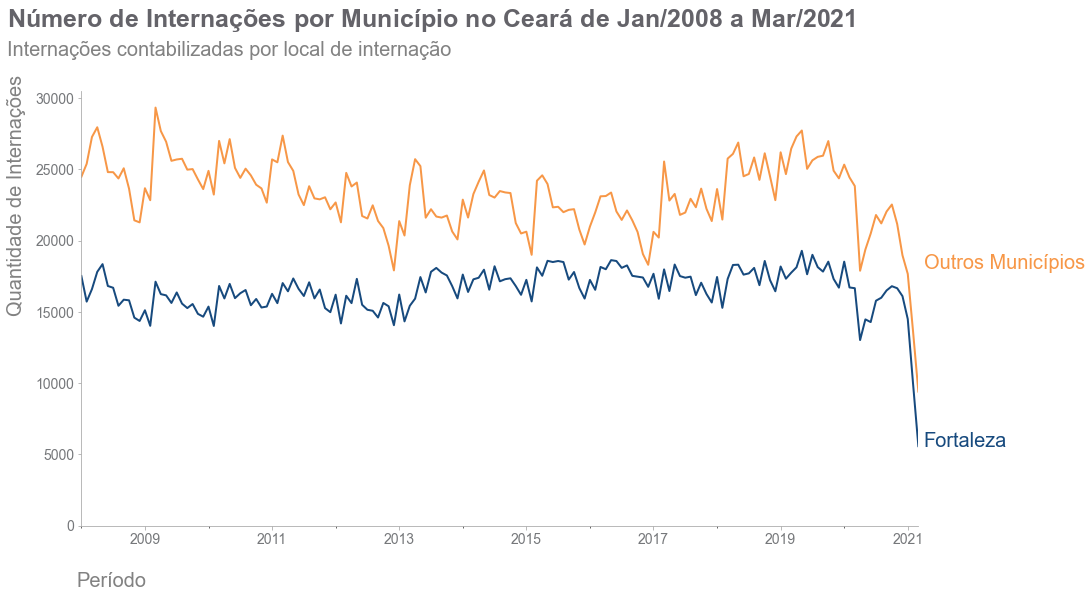

In [50]:
color = [BLUE1, ORANGE1]

ax = intern_munic_local.plot(figsize = (15, 8), color = color, legend = None, linewidth = 2)

ax.set_yticks(range(0, 30001, 5000))

ax.tick_params(color = 'darkgrey')
ax.spines['bottom'].set_color('darkgrey')
ax.spines['left'].set_color('darkgrey')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(14)
    i.set_color(GRAY5)
    
# número de internações por município do Ceará por local de internação
    
plt.text(442, 35000, '$\\bf{Número\ de\ Internações\ por\ Município\ no\ Ceará\ de\ Jan/2008\ a\ Mar/2021}$',
         fontsize = 25, color = GRAY4)
plt.text(442, 33000, 'Internações contabilizadas por local de internação',
         fontsize = 20, color = GRAY6)

plt.text(442, 15000, 'Quantidade de Internações', fontsize = 20, rotation = 'vertical', color = GRAY6)
plt.text(455, -4300, 'Período', fontsize = 20, color = GRAY6)

plt.text(615, 5500, 'Fortaleza', fontsize = 20, color = BLUE1)
plt.text(615, 18000, 'Outros Municípios', fontsize = 20, color = ORANGE1)

plt.show()

In [51]:
intern_munic_local = intern_munic_local.T

In [52]:
intern_munic_local = intern_munic_local.astype('float64')

In [53]:
intern_munic_local['Soma'] = intern_munic_local.sum(axis = 1)

In [54]:
intern_munic_local['Porcentagem'] = (intern_munic_local['Soma'] / intern_munic_local['Soma'].sum()) * 100

In [55]:
print('O número de internações de Fortaleza corresponde a {:.2f}% do total do Estado do Ceará,\
        \ncontra todos os outros 183 municípios correspondendo a {:.2f}% do total.'.format(intern_munic_local['Porcentagem']['Fortaleza'],
                                                                                          intern_munic_local['Porcentagem']['Soma']))

O número de internações de Fortaleza corresponde a 41.62% do total do Estado do Ceará,        
contra todos os outros 183 municípios correspondendo a 58.38% do total.


## 5.3 Conclusões

Considerando o número de internações por município no Estado do Ceará, por local de internação, temos que:
- O número de internações de Fortaleza corresponde a 41,62% do total do Estado do Ceará e        
- Todos os outros 183 municípios correspondem a 58,38% do total.

# 6 Número de Internações por Município do Ceará - Por Local de Residência

Agora iremos comparar o número de internações por local de residência no Estado do Ceará. Isso é importante para termos um comparação com o caso anterior, do número de internações por local de internação.

## 6.1 Carregamento & Limpeza dos Dados

In [56]:
# número de internações por município do Ceará por local de residência
intern_munic_resid_raw = pd.read_csv('../data/intern_muni_ce_por_local_de_residencia.csv', sep = ';', encoding = 'ISO-8859-1', skiprows = 3,
                            skipfooter = 13, thousands = '.', decimal = ',', engine = 'python')

In [57]:
intern_munic_resid_raw.head(3)

,Município,2007/Jan,2007/Fev,2007/Jul,2007/Ago,2007/Set,2007/Out,2007/Nov,2007/Dez,2008/Jan,...,2020/Jul,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar,Total
0,230010 Abaiara,-,-,-,-,1,2,7,9,33,...,21,31,33,35,24,25,23,6,6,6392
1,230015 Acarape,-,-,-,-,3,2,3,15,81,...,78,51,34,53,58,50,58,36,14,9966
2,230020 Acaraú,-,-,-,-,1,6,19,76,289,...,216,176,169,240,291,270,207,31,11,41614


Hora de limpar esses dados!

In [58]:
# cópia do dataframe original
intern_munic_resid = intern_munic_resid_raw.copy()

# remover os 6 números iniciais dos nomes dos municípios
intern_munic_resid['Município'] = intern_munic_resid['Município'].str[7:]

# coloca a coluna Município como índice
intern_munic_resid = intern_munic_resid.set_index('Município').rename_axis(None)

intern_munic_resid.columns

Index(['2007/Jan', '2007/Fev', '2007/Jul', '2007/Ago', '2007/Set', '2007/Out',
       '2007/Nov', '2007/Dez', '2008/Jan', '2008/Fev',
       ...
       '2020/Jul', '2020/Ago', '2020/Set', '2020/Out', '2020/Nov', '2020/Dez',
       '2021/Jan', '2021/Fev', '2021/Mar', 'Total'],
      dtype='object', length=168)

Vemos que as 8 primeiras colunas correspondem ao ano de 2007. Vamos removê-las, pois começaremos nossas análises a partir de Janeiro de 2008.

In [59]:
intern_munic_resid = intern_munic_resid[intern_munic_resid.columns[8:]]
intern_munic_resid.head(3)

,2008/Jan,2008/Fev,2008/Mar,2008/Abr,2008/Mai,2008/Jun,2008/Jul,2008/Ago,2008/Set,2008/Out,...,2020/Jul,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar,Total
Abaiara,33,47,47,39,33,32,50,46,45,53,...,21,31,33,35,24,25,23,6,6,6392
Acarape,81,62,75,62,79,44,51,43,64,44,...,78,51,34,53,58,50,58,36,14,9966
Acaraú,289,334,313,318,306,282,274,248,310,270,...,216,176,169,240,291,270,207,31,11,41614


In [60]:
intern_munic_resid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 184 entries, Abaiara to Viçosa do Ceará
Columns: 160 entries, 2008/Jan to Total
dtypes: int64(159), object(1)
memory usage: 231.4+ KB


Aqui temos apenas uma coluna do tipo ```object```. Vamos encontrá-la.

In [61]:
intern_munic_resid.select_dtypes(object).head()

,2021/Mar
Abaiara,6
Acarape,14
Acaraú,11
Acopiara,95
Aiuaba,27


Então provavelmente temos algum valor faltante na coluna '2021/Mar'. Isso condiz com o que viemos falando até aqui, que os valores dos últimos meses ainda não estão completos.

In [62]:
intern_munic_resid = intern_munic_resid.replace('-', 0)

In [63]:
intern_munic_resid['2021/Mar'] = intern_munic_resid['2021/Mar'].astype('int64')

In [64]:
intern_munic_resid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 184 entries, Abaiara to Viçosa do Ceará
Columns: 160 entries, 2008/Jan to Total
dtypes: int64(160)
memory usage: 231.4+ KB


Agora temos todas as colunas do tipo ```int64```.

In [65]:
intern_munic_resid.columns

Index(['2008/Jan', '2008/Fev', '2008/Mar', '2008/Abr', '2008/Mai', '2008/Jun',
       '2008/Jul', '2008/Ago', '2008/Set', '2008/Out',
       ...
       '2020/Jul', '2020/Ago', '2020/Set', '2020/Out', '2020/Nov', '2020/Dez',
       '2021/Jan', '2021/Fev', '2021/Mar', 'Total'],
      dtype='object', length=160)

Ainda temos uma coluna 'Total', iremos removê-la.

In [66]:
intern_munic_resid = intern_munic_resid.drop('Total', axis = 1)

Agora só nos resta separar o dataframe em duas colunas: Fortaleza e Outros Municípios.

In [67]:
# convertendo o "Ano/Mês" para datetime
intern_munic_resid.columns = pd.to_datetime(intern_munic_resid.columns, format='%Y/%b')

In [68]:
intern_munic_resid = intern_munic_resid.T

In [69]:
intern_munic_resid['Soma'] = intern_munic_resid.drop(['Fortaleza'], axis = 1).sum(axis = 1)

In [70]:
intern_munic_resid = intern_munic_resid[['Fortaleza', 'Soma']]

In [71]:
intern_munic_resid.head()

,Fortaleza,Soma
2008-01-01,13202,28718
2008-02-01,11893,29154
2008-03-01,12462,31403
2008-04-01,13741,31978
2008-05-01,14252,30652


Pronto, já temos o que queremos e podemos analisar graficamente.

## 6.1 Análise Gráfica

Vamos observar como Fortaleza se compara à soma de todos os outros 183 municípios do Estado do Ceará no número de internações, por local de residência, no período analisado (jan/2008 a mar/2021).

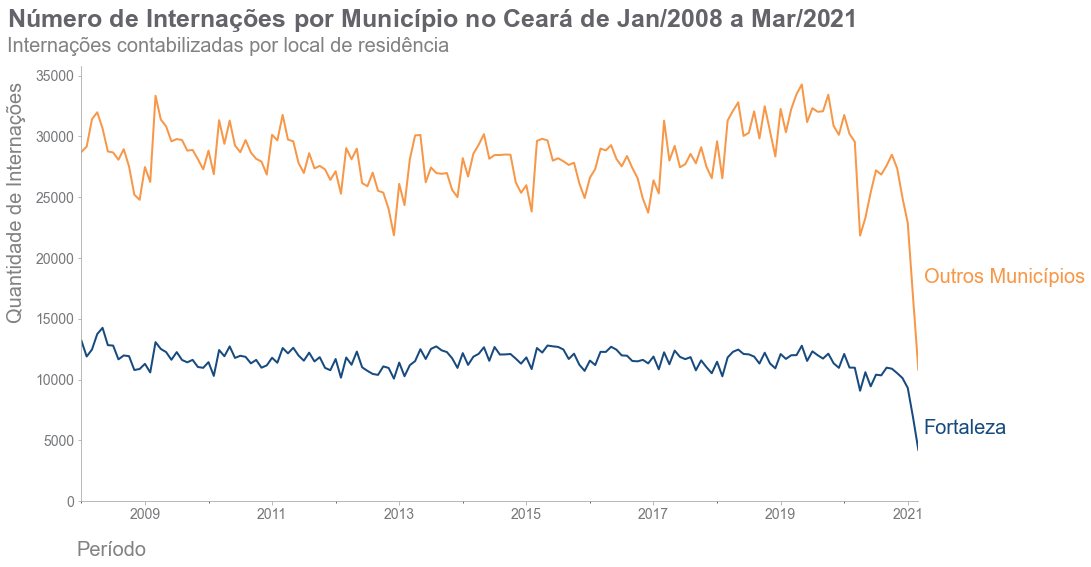

In [72]:
color = [BLUE1, ORANGE1]

ax = intern_munic_resid.plot(figsize = (15, 8), color = color, legend = None, linewidth = 2)

ax.set_yticks(range(0, 35001, 5000))

ax.tick_params(color = 'darkgrey')
ax.spines['bottom'].set_color('darkgrey')
ax.spines['left'].set_color('darkgrey')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(14)
    i.set_color(GRAY5)
    
# número de internações por município do Ceará por local de internação
    
plt.text(442, 39000, '$\\bf{Número\ de\ Internações\ por\ Município\ no\ Ceará\ de\ Jan/2008\ a\ Mar/2021}$',
         fontsize = 25, color = GRAY4)
plt.text(442, 37000, 'Internações contabilizadas por local de residência',
         fontsize = 20, color = GRAY6)

plt.text(442, 15000, 'Quantidade de Internações', fontsize = 20, rotation = 'vertical', color = GRAY6)
plt.text(455, -4500, 'Período', fontsize = 20, color = GRAY6)

plt.text(615, 5500, 'Fortaleza', fontsize = 20, color = BLUE1)
plt.text(615, 18000, 'Outros Municípios', fontsize = 20, color = ORANGE1)

plt.show()

Logo de cara já podemos ver que, comparado ao número de internações geral, o número de internações por local de residência mostra uma figura diferente sobre os dados.

Aqui temos uma disparidade maior entre Fortaleza e os outros munícipios. Esse gráfico e o anterior mostram bem a hipótese de que muitas pessoas de outros municípios realizam a internação em Fortaleza. Isso é totalmente compreensível, pela disparidade de recursos de cada localidade, como na sessão seguinte.

In [73]:
intern_munic_resid = intern_munic_resid.T

In [74]:
intern_munic_resid['Soma'] = intern_munic_resid.sum(axis = 1)

In [75]:
intern_munic_resid['Porcentagem'] = (intern_munic_resid['Soma'] / intern_munic_resid['Soma'].sum()) * 100

In [76]:
print('O número de internações de Fortaleza corresponde a {:.2f}% do total do Estado do Ceará,\
      \nconsiderando o local de residência, contra todos os outros 183 municípios correspondendo a {:.2f}% do total.'.format(intern_munic_resid['Porcentagem']['Fortaleza'],
                                                                                                                             intern_munic_resid['Porcentagem']['Soma']))

O número de internações de Fortaleza corresponde a 29.12% do total do Estado do Ceará,      
considerando o local de residência, contra todos os outros 183 municípios correspondendo a 70.88% do total.


## 6.3 Conclusões

Considerando o número de internações por município no Estado do Ceará, por local de residência, temos que:
- 29,12% de todas as internações do Ceará são de pessoas que residem em Fortaleza e
- 70,88% das internações são de pessoas que residem em qualquer um dos outros 183 municípios do Ceará.

Como isso se compara com a população total?
- Em 2018 foi estimado que [Fortaleza](https://pt.wikipedia.org/wiki/Fortaleza) possui 2,6 milhões de habitantes. Isso corresponde a 29,60% da população do [Ceará](https://pt.wikipedia.org/wiki/Ceará), estimada em 9 milhões de habitantes.
- A soma de todos os habitantes de todos os outros municípios corresponde a 70,40% da população do Estado.

Com isso, vemos que os dados das internações por local de residência estão bastante coerentes com a população.

# 7 Total de Gastos com Internação - Brasil

Agora vamos avaliar e analisar o valor total utilizado por internações para vermos se há alguma relação com o número de internações de cada local.

## 7.1 Carregamento & Limpeza dos Dados

In [77]:
valor_total_br = pd.read_csv('../data/valor_total_brasil.csv', sep = ';', encoding = 'ISO-8859-1', skiprows = 3,
                            skipfooter = 13, thousands = '.', decimal = ',', engine = 'python')

In [78]:
valor_total_br.head(3)

,Unidade da Federação,1992/Mar,1992/Abr,1993/Mai,1993/Dez,1994/Jan,1994/Fev,1994/Mai,1994/Ago,1994/Nov,...,2020/Jul,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar,Total
0,11 Rondônia,-,-,-,-,-,-,-,-,-,...,10479989.36,11433467.56,8876900.39,8167253.19,8759013.71,9003402.23,8414690.60,6039419.59,4732441.04,996411254.68
1,12 Acre,-,-,-,-,-,-,-,-,-,...,4053085.41,3658265.59,3470409.45,3267918.69,3393958.27,3711660.71,3005561.16,2272733.90,1137341.65,450048530.47
2,13 Amazonas,-,-,-,-,-,-,-,-,-,...,19303743.16,18687233.58,18628627.49,18728251.20,20451573.77,21546059.48,24439059.57,13679358.06,6799060.80,1917247936.05


Hora de limpar esses dados!

In [79]:
# cópia do dataframe original
valortotalbr = valor_total_br.copy()

# remover os números dos nomes das UFs
# podemos fazer isso pois usamos outro método pra separar por regiões
valortotalbr['Unidade da Federação'] = valortotalbr['Unidade da Federação'].str[3:]

# colocando a coluna de UFs como índice
valortotalbr = valortotalbr.set_index('Unidade da Federação').rename_axis(None)

Vamos encontrar em qual posição está a coluna '2008/Jan' e fazer um slice para nosso dataframe iniciar a partir dela.

In [80]:
valortotalbr.columns.get_loc('2008/Jan')

126

In [81]:
# fazendo o slicing
valortotalbr = valortotalbr[valortotalbr.columns[126:]]

In [82]:
valortotalbr.head(3)

,2008/Jan,2008/Fev,2008/Mar,2008/Abr,2008/Mai,2008/Jun,2008/Jul,2008/Ago,2008/Set,2008/Out,...,2020/Jul,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar,Total
Rondônia,1829559.71,1940792.63,1955721.68,2143353.81,2280382.58,2624542.97,2973421.02,2938286.29,2843930.91,2878153.20,...,10479989.36,11433467.56,8876900.39,8167253.19,8759013.71,9003402.23,8414690.60,6039419.59,4732441.04,996411254.68
Acre,1731744.62,1743978.66,2057439.02,2057829.69,2226577.93,2112576.82,2029128.01,1886871.84,2084884.80,2230838.45,...,4053085.41,3658265.59,3470409.45,3267918.69,3393958.27,3711660.71,3005561.16,2272733.90,1137341.65,450048530.47
Amazonas,11419210.08,7934652.10,8641517.13,8531576.49,9079902.15,8646295.77,8755806.50,8331763.97,8148089.92,7681661.02,...,19303743.16,18687233.58,18628627.49,18728251.20,20451573.77,21546059.48,24439059.57,13679358.06,6799060.80,1917247936.05


Será que todos os valores estão completos? Vamos conferir!

In [83]:
valortotalbr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26 entries, Rondônia to Goiás
Columns: 160 entries, 2008/Jan to Total
dtypes: float64(160)
memory usage: 32.7+ KB


Todas as colunas são do tipo ```float64```, então não temos nenhum valor que foi subsituído por hífen ou algo do tipo. Ainda bem!

Vamos remover a coluna 'Total'. Caso precisemos do total dos valores, podemos facilmente somá-los.

In [84]:
valortotalbr = valortotalbr.drop('Total', axis = 1)

Finalmente, vamos converter as colunas para o formato de data.

In [85]:
valortotalbr.columns = pd.to_datetime(valortotalbr.columns, format = '%Y/%b')

In [86]:
valortotalbr.head(3)

,2008-01-01,2008-02-01,2008-03-01,2008-04-01,2008-05-01,2008-06-01,2008-07-01,2008-08-01,2008-09-01,2008-10-01,...,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,2021-01-01,2021-02-01,2021-03-01
Rondônia,1829559.71,1940792.63,1955721.68,2143353.81,2280382.58,2624542.97,2973421.02,2938286.29,2843930.91,2878153.20,...,10993332.84,10479989.36,11433467.56,8876900.39,8167253.19,8759013.71,9003402.23,8414690.60,6039419.59,4732441.04
Acre,1731744.62,1743978.66,2057439.02,2057829.69,2226577.93,2112576.82,2029128.01,1886871.84,2084884.80,2230838.45,...,3914823.86,4053085.41,3658265.59,3470409.45,3267918.69,3393958.27,3711660.71,3005561.16,2272733.90,1137341.65
Amazonas,11419210.08,7934652.10,8641517.13,8531576.49,9079902.15,8646295.77,8755806.50,8331763.97,8148089.92,7681661.02,...,18433057.47,19303743.16,18687233.58,18628627.49,18728251.20,20451573.77,21546059.48,24439059.57,13679358.06,6799060.80


Agora parece que está tudo certo e podemos começar a analisar graficamente.

## 7.2 Análise Gráfica

Aqui seguiremos o mesmo modelo anterior, de analisar por país, por Região e finalmente por Estado.

In [87]:
# separar por regiões

norte = valortotalbr.index[:7].tolist()
nordeste = valortotalbr.index[7:16].tolist()
sudeste = valortotalbr.index[16:20].tolist()
sul = valortotalbr.index[20:23].tolist()
centro_oeste = valortotalbr.index[23:].tolist()

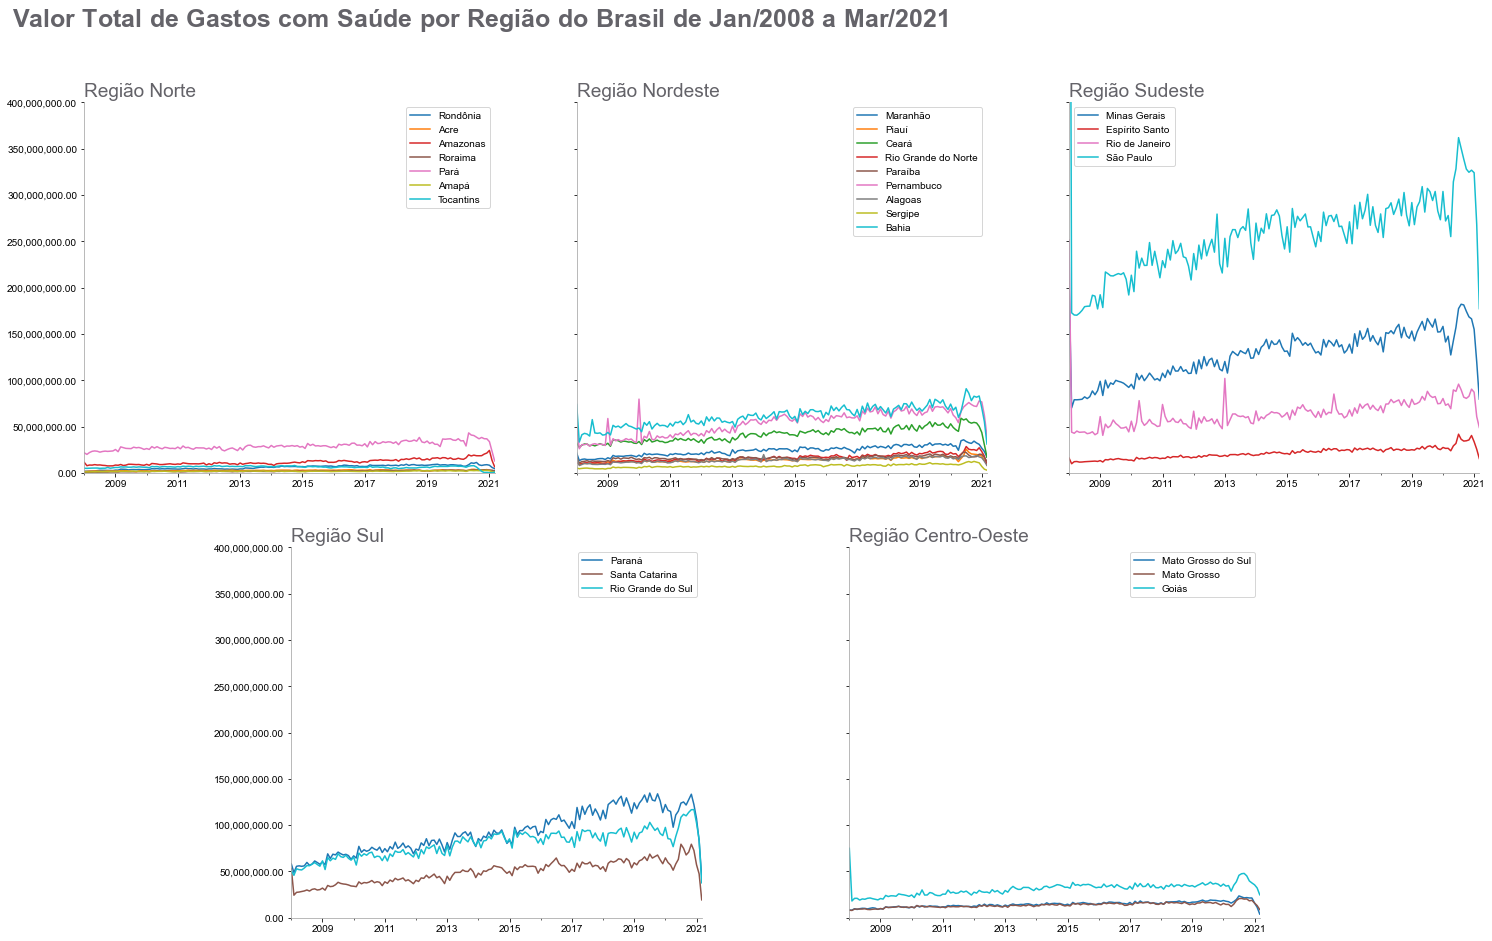

In [88]:
fig, axes = plt.subplots(2, 3, sharey = True, figsize = (25, 15))

fig.text(0.085, 0.95, '$\\bf{Valor\ Total\ de\ Gastos\ com\ Saúde\ por\ Região\ do\ Brasil\ de\ Jan/2008\ a\ Mar/2021}$',
         fontsize = 25, color = GRAY4)

# foi necessário dar um limite para o eixo y pois os gastos do sudeste
# possuem um pico muito elevado no início que estava deturpando a plotagem
plt.ylim(0, 400000000)

axes[1, 2].set_visible(False)

valortotalbr.loc[norte].T.plot(ax = axes[0, 0], colormap = 'tab10')
axes[0, 0].set_title('Região Norte', loc = 'left', fontsize = 19, color = GRAY4)
axes[0, 0].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
axes[0, 0].spines['bottom'].set_color('darkgrey')
axes[0, 0].spines['left'].set_color('darkgrey')
axes[0, 0].spines['right'].set_visible(False)
axes[0, 0].spines['top'].set_visible(False)

valortotalbr.loc[nordeste].T.plot(ax = axes[0, 1], colormap = 'tab10')
axes[0, 1].set_title('Região Nordeste', loc = 'left', fontsize = 19, color = GRAY4)
axes[0, 1].spines['bottom'].set_color('darkgrey')
axes[0, 1].spines['left'].set_color('darkgrey')
axes[0, 1].spines['right'].set_visible(False)
axes[0, 1].spines['top'].set_visible(False)

valortotalbr.loc[sudeste].T.plot(ax = axes[0, 2], colormap = 'tab10')
axes[0, 2].set_title('Região Sudeste', loc = 'left', fontsize = 19, color = GRAY4)
axes[0, 2].spines['bottom'].set_color('darkgrey')
axes[0, 2].spines['left'].set_color('darkgrey')
axes[0, 2].spines['right'].set_visible(False)
axes[0, 2].spines['top'].set_visible(False)

valortotalbr.loc[sul].T.plot(ax = axes[1, 0], colormap = 'tab10')
axes[1, 0].set_title('Região Sul', loc = 'left', fontsize = 19, color = GRAY4)
axes[1, 0].spines['bottom'].set_color('darkgrey')
axes[1, 0].spines['left'].set_color('darkgrey')
axes[1, 0].spines['right'].set_visible(False)
axes[1, 0].spines['top'].set_visible(False)

valortotalbr.loc[centro_oeste].T.plot(ax = axes[1, 1], colormap = 'tab10')
axes[1, 1].set_title('Região Centro-Oeste', loc = 'left', fontsize = 19, color = GRAY4)
axes[1, 1].spines['bottom'].set_color('darkgrey')
axes[1, 1].spines['left'].set_color('darkgrey')
axes[1, 1].spines['right'].set_visible(False)
axes[1, 1].spines['top'].set_visible(False)

axes[1][0].set_position([0.24, 0.125, 0.228, 0.343])
axes[1][1].set_position([0.55, 0.125, 0.228, 0.343])

plt.show()

Os gráficos possuem os mesmos eixos x e y, para uma melhor comparação dos valores dos gastos. Aqui temos uma visualização, novamente, mais geral, e, caráter de comparação entre as regiões, e não entre os estados em si, por isso não é tão danoso haver alguma dificuldade em distinguir exatamente cada estado.

O pico de gastos no início do gráfico da região sudeste representa valores inseridos retroativamente na base de dados, por isso preferi desconsiderar e limitar o eixo y.

Vamos agora ver o total por região.

In [89]:
valortotalord = valortotalbr.copy()
valortotalord['Soma'] = valortotalord.sum(axis = 1)
valortotalord['Porcentagem'] = (valortotalord['Soma'] / valortotalord['Soma'].sum()) * 100

In [90]:
print('A posição do Ceará no valor total de gastos no Brasil é: {}.'.format(valortotalord.index.get_loc('Ceará') + 1))

A posição do Ceará no valor total de gastos no Brasil é: 10.


In [91]:
# dataframe auxiliar para plotagem
vto = valortotalord['Soma']
vto = vto.sort_values(ascending = False)

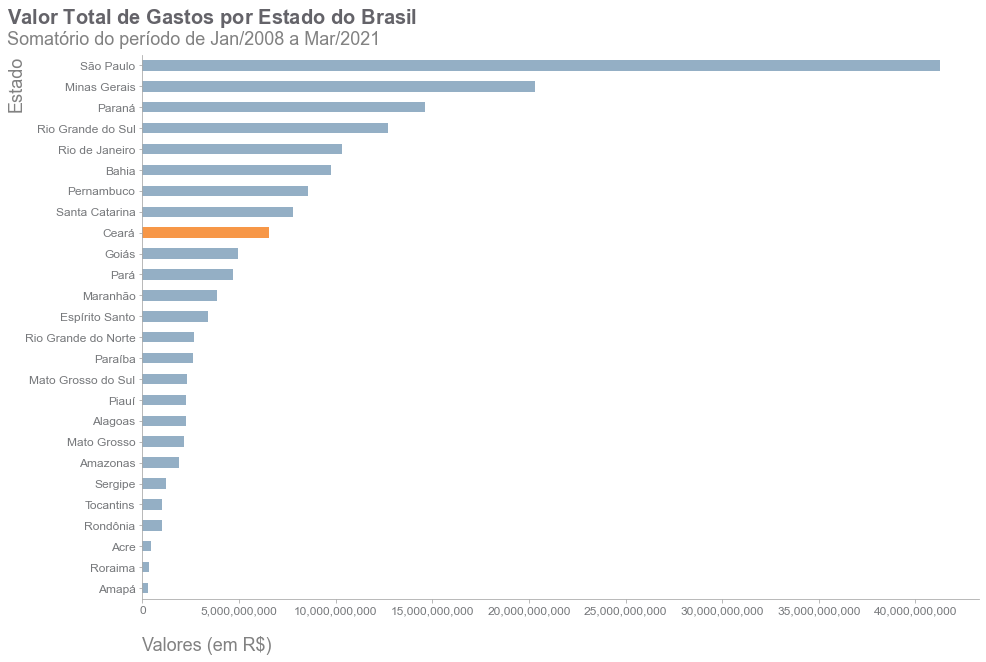

In [92]:
cores = []
for value in vto.keys():
    if 'Ceará' == value:
        cores.append(ORANGE1)
    else:
        cores.append(BLUE4)
cores.reverse()

ax = vto.sort_values(ascending = True).plot(kind = 'barh', figsize = (15, 10), color = cores)

ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.tick_params(color = 'darkgrey', bottom = 'off')
ax.spines['bottom'].set_color('darkgrey')
ax.spines['left'].set_color('darkgrey')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(12)
    i.set_color(GRAY5)
    
# remover o número do nome dos Estados
#ax.set_yticklabels([k[3:] for k in internacoes_ord.index.to_list()[::-1]])
    
plt.text(-7000000000, 27, '$\\bf{Valor\ Total\ de\ Gastos\ por\ Estado\ do\ Brasil}$',
         fontsize = 20, color = GRAY4)
plt.text(-7000000000, 26, 'Somatório do período de Jan/2008 a Mar/2021',
         fontsize = 18, color = GRAY6)

plt.text(-7000000000, 23, 'Estado', fontsize = 18, rotation = 'vertical', color = GRAY6)
plt.text(455, -3, 'Valores (em R$)', fontsize = 18, color = GRAY6)

plt.show()

In [93]:
print('O valor total do Ceará corresponde a {:.2f}% do total do Brasil, \
       \nou seja, {} bilhões no período de Jan/2008 a  Mar/2021.'.format(valortotalord['Porcentagem']['Ceará'],
                                                                         locale.currency(valortotalord['Soma']['Ceará'], grouping = True)))

O valor total do Ceará corresponde a 3.88% do total do Brasil,        
ou seja, R$ 6.573.100.152,04 bilhões no período de Jan/2008 a  Mar/2021.


In [94]:
# dataframe auxiliar para a plotagem gráfica
valor_total_regioes = valortotalbr.copy()
valor_total_regioes = valor_total_regioes.T

valor_total_regioes['Nordeste'] = valor_total_regioes[nordeste].sum(axis = 1)
valor_total_regioes['Norte'] = valor_total_regioes[norte].sum(axis = 1)
valor_total_regioes['Sudeste'] = valor_total_regioes[sudeste].sum(axis = 1)
valor_total_regioes['Sul'] = valor_total_regioes[sul].sum(axis = 1)
valor_total_regioes['Centro_Oeste'] = valor_total_regioes[centro_oeste].sum(axis = 1)

valor_total_regioes = valor_total_regioes[['Nordeste', 'Norte', 'Sudeste', 'Sul', 'Centro_Oeste']]

valor_total_regioes.head()

,Nordeste,Norte,Sudeste,Sul,Centro_Oeste
2008-01-01,240952019.39,44017418.18,1511999605.49,162180329.15,91553458.20
2008-02-01,143170221.70,38844188.02,297424135.24,119162324.20,34358557.99
2008-03-01,164001219.48,42058042.63,304838597.77,136023967.49,40202469.49
2008-04-01,169546980.47,43806481.51,307144452.15,135894194.03,39437608.08
2008-05-01,169304560.50,45231240.95,307471263.54,135608462.24,38382852.63


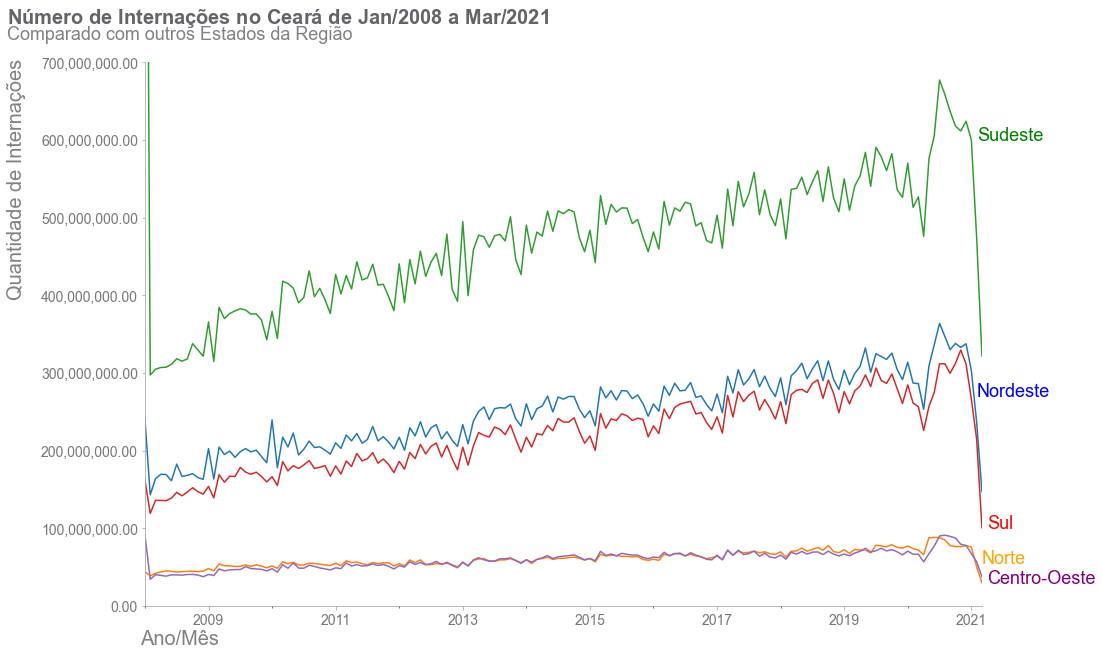

In [95]:
ax = valor_total_regioes.plot(figsize = (15, 10))

# foi necessário dar um limite para o eixo y pois os gastos do sudeste
# possuem um pico muito elevado no início que estava deturpando a plotagem
plt.ylim(0, 700000000)

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
ax.tick_params(color = 'darkgrey')
ax.spines['bottom'].set_color('darkgrey')
ax.spines['left'].set_color('darkgrey')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(14)
    i.set_color(GRAY5)


plt.text(430, 750000000, '$\\bf{Número\ de\ Internações\ no\ Ceará\ de\ Jan/2008\ a\ Mar/2021}$',
         fontsize = 20, color = GRAY4)
plt.text(430, 730000000, 'Comparado com outros Estados da Região',
         fontsize = 18, color = GRAY6)

plt.text(430, 400000000, 'Quantidade de Internações', fontsize = 20, rotation = 'vertical', color = GRAY6)
plt.text(455, -50000000, 'Ano/Mês', fontsize = 20, color = GRAY6)

plt.text(613, 600000000, 'Sudeste', fontsize = 18, color = 'green')
plt.text(613, 270000000, 'Nordeste', fontsize = 18, color = 'blue')
plt.text(615, 100000000, 'Sul', fontsize = 18, color = 'red')
plt.text(614, 55000000, 'Norte', fontsize = 18, color = 'orange')
plt.text(615, 29000000, 'Centro-Oeste', fontsize = 18, color = 'purple')

ax.get_legend().remove()

plt.show()

É fácil ver a ordem de gastos pelas Regiões do país. Também é evidente um crescimento no valor total.

Além disso, os valores totais da regiões Norte e Centro-Oeste são extremamente parecidos.

In [96]:
valor_total_regioes = valor_total_regioes.T
valor_total_regioes['Soma'] = valor_total_regioes.sum(axis = 1)
valor_total_regioes['Porcentagem'] = (valor_total_regioes['Soma'] / valor_total_regioes['Soma'].sum()) * 100

In [97]:
valor_total_regioes

,2008-01-01 00:00:00,2008-02-01 00:00:00,2008-03-01 00:00:00,2008-04-01 00:00:00,2008-05-01 00:00:00,2008-06-01 00:00:00,2008-07-01 00:00:00,2008-08-01 00:00:00,2008-09-01 00:00:00,2008-10-01 00:00:00,...,2020-08-01 00:00:00,2020-09-01 00:00:00,2020-10-01 00:00:00,2020-11-01 00:00:00,2020-12-01 00:00:00,2021-01-01 00:00:00,2021-02-01 00:00:00,2021-03-01 00:00:00,Soma,Porcentagem
Nordeste,240952019.39,143170221.70,164001219.48,169546980.47,169304560.50,161318366.37,182631707.98,166813086.44,168149195.92,170330608.76,...,346811017.19,330051638.64,338072723.83,332959043.31,337653457.67,303137575.92,236993044.50,147310471.48,39728504370.30,23.46
Norte,44017418.18,38844188.02,42058042.63,43806481.51,45231240.95,44643930.10,43735684.31,44224992.50,44499904.46,44847041.79,...,85026192.77,77683340.37,76498384.66,76398561.75,77816578.09,75817801.87,50330800.76,30038164.35,9689317216.76,5.72
Sudeste,1511999605.49,297424135.24,304838597.77,307144452.15,307471263.54,311112979.67,318343757.89,315264065.71,318114199.55,337872933.48,...,658645521.01,636672793.85,618012246.78,611680518.74,624291459.06,600149078.07,474613196.92,321945408.30,75301640583.15,44.47
Sul,162180329.15,119162324.20,136023967.49,135894194.03,135608462.24,138847721.51,146243505.53,141820614.49,146727875.55,152232461.75,...,311912963.93,299717511.18,312386479.09,329630327.74,311700903.76,266548376.08,214964151.28,100655384.43,35146729865.61,20.76
Centro_Oeste,91553458.20,34358557.99,40202469.49,39437608.08,38382852.63,40071079.48,39980174.95,39645646.71,40526130.49,40661951.83,...,91112647.35,89646674.30,87517783.36,79520697.08,77854113.94,67574203.69,56890230.89,37738880.88,9447853390.66,5.58


In [98]:
print('A Região Nordeste possui {:.2f}% do valor total gasto no país no período analisado.'.format(valor_total_regioes['Porcentagem']['Nordeste']))

A Região Nordeste possui 23.46% do valor total gasto no país no período analisado.


In [99]:
valor_total_nordeste = valortotalbr.copy()

valor_total_nordeste = valor_total_nordeste.loc[nordeste]

valor_total_nordeste['Soma'] = valor_total_nordeste.sum(axis = 1)

valor_total_nordeste = valor_total_nordeste.sort_values(by = 'Soma', ascending = False)

valor_total_nordeste = valor_total_nordeste.drop('Soma', axis = 1)

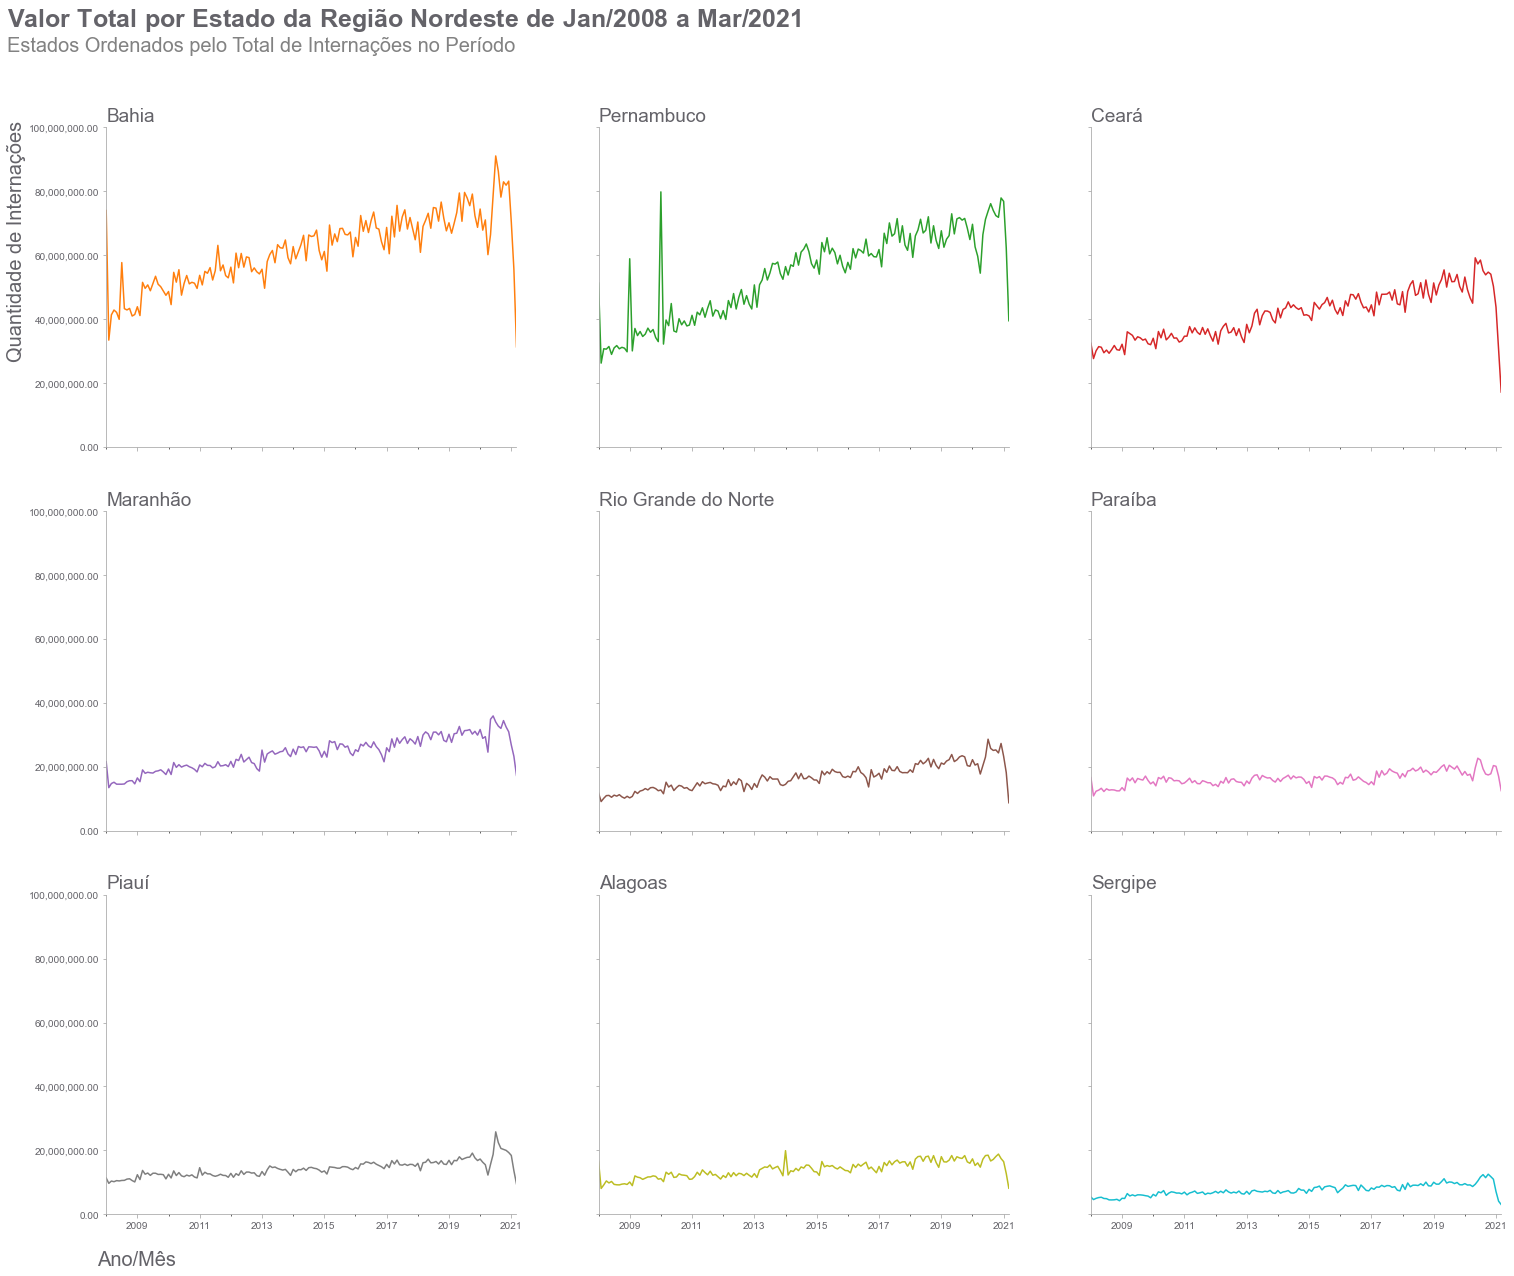

In [100]:
fig, axes = plt.subplots(3, 3, sharex = True, sharey = True, figsize = (25, 20))

palette = plt.get_cmap('tab10')

fig.text(0.070, 0.95, '$\\bf{Valor\ Total\ por\ Estado\ da\ Região\ Nordeste\ de\ Jan/2008\ a\ Mar/2021}$',
         fontsize = 25, color = GRAY4)
fig.text(0.070, 0.933, 'Estados Ordenados pelo Total de Internações no Período',
         fontsize = 20, color = GRAY6)

fig.text(0.070, 0.72, 'Quantidade de Internações', fontsize = 20, rotation = 'vertical', color = GRAY4)
fig.text(0.12, 0.09, 'Ano/Mês', fontsize = 20, color = GRAY4)

num = 0

for estado in valor_total_nordeste.index.tolist():
    num += 1
    plt.subplot(3, 3, num)
    ax = valor_total_nordeste.loc[estado].T.plot(color = palette(num))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
    plt.ylim(0, 100000000)
    if num in range(7) :
        plt.tick_params(labelbottom = False)
    if num not in [1,4,7] :
        plt.tick_params(labelleft = False)
    plt.title(estado, loc = 'left', fontsize = 19, color = GRAY4)
    
    for i in ax.get_yticklabels() + ax.get_xticklabels():
        i.set_fontsize(10)
        i.set_color(GRAY4)
    
    ax.tick_params(color = 'darkgrey', bottom = True)
    ax.spines['bottom'].set_color('darkgrey')
    ax.spines['left'].set_color('darkgrey')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
#plt.suptitle("Número de Internações por Estado da Região Nordeste de Jan/2008 a Mar/2021\nOrdenados pelo Total de Gastos",
#             fontsize = 20, fontweight = 5, color = GRAY4, style = 'italic', y = 0.95, x = 0.1, ha = 'left')

plt.show()

Os três primeiros estados do Nordeste com mais gastos acompanham os mesmos três estados com os maiores números de internação. E com uma tendência de crescimento maior nesses estados.

In [101]:
valor_total_nord = valor_total_nordeste.copy()
valor_total_nord['Soma'] = valor_total_nord.sum(axis = 1)
valor_total_nord['Porcentagem'] = (valor_total_nord['Soma'] / valor_total_nord['Soma'].sum()) * 100

In [102]:
valor_total_nord

,2008-01-01 00:00:00,2008-02-01 00:00:00,2008-03-01 00:00:00,2008-04-01 00:00:00,2008-05-01 00:00:00,2008-06-01 00:00:00,2008-07-01 00:00:00,2008-08-01 00:00:00,2008-09-01 00:00:00,2008-10-01 00:00:00,...,2020-08-01 00:00:00,2020-09-01 00:00:00,2020-10-01 00:00:00,2020-11-01 00:00:00,2020-12-01 00:00:00,2021-01-01 00:00:00,2021-02-01 00:00:00,2021-03-01 00:00:00,Soma,Porcentagem
Bahia,73947845.87,33410124.06,41316672.72,42826993.62,42086263.49,39910042.40,57664560.93,43254543.33,42851268.02,43332573.68,...,86230665.84,78135509.62,82912397.81,81866088.87,83131785.74,70325599.07,55544579.04,31314602.44,9774232837.70,24.60
Pernambuco,51261210.58,26222079.10,30716361.81,30589332.79,31420089.90,28947510.92,30985515.77,31705296.79,30703879.20,31165074.59,...,76091056.19,73964434.93,72356982.69,71810830.78,77877186.72,76810042.34,62259409.32,39472738.81,8552834273.47,21.53
Ceará,32444328.54,27643304.86,30085370.22,31376221.00,31189904.62,29463965.11,30302691.99,29304821.51,30435026.82,31741382.87,...,55118185.83,53827491.88,54679652.99,54026288.42,50271552.33,43743425.74,30186951.00,17173151.55,6573100152.04,16.55
Maranhão,21551600.33,13452263.93,14750895.33,15148647.11,14543679.92,14553978.06,14536700.20,14609872.57,15317881.85,15617699.59,...,32711259.43,31985709.32,34430463.50,32446802.41,30927070.93,26797697.76,23260245.95,17294509.11,3854161978.61,9.70
Rio Grande do Norte,11763899.23,9110108.87,10126626.54,10964234.85,11032871.23,10450599.08,11119053.52,10812840.19,11258681.53,10572190.95,...,25721339.11,25098604.18,25257993.78,24312931.74,27277816.41,23228004.80,18186942.80,8733455.36,2652547796.60,6.68
Paraíba,16599004.84,10871589.62,12348758.14,12680965.13,13258411.71,12246686.33,13090842.60,12673774.35,12790639.17,12727661.14,...,19346119.89,17712791.83,17427250.61,17799651.06,20355212.85,20149018.68,16996494.03,12517894.05,2605830202.48,6.56
Piauí,11375419.37,9711680.20,10428191.09,10227943.00,10562148.66,10465088.93,10618079.70,10645917.52,11037940.55,11143375.71,...,22452255.50,20636997.20,20326808.24,20021998.76,19352220.14,18437275.64,13636005.36,9542151.53,2271886591.52,5.72
Alagoas,16568724.64,8112220.30,9210505.56,10466691.94,9844096.03,10299459.18,9385440.40,9262767.68,9228201.96,9464597.85,...,16706034.11,17201473.11,18109194.42,18857578.34,17462663.52,16496784.27,12792571.64,8180887.21,2231837294.69,5.62
Sergipe,5439985.99,4636850.76,5017838.07,5265951.03,5367094.94,4981036.36,4928822.87,4543252.50,4525676.82,4566052.38,...,12434101.29,11488626.57,12571979.79,11816872.93,10997949.03,7149727.62,4129845.36,3081081.42,1212073243.19,3.05


In [103]:
print('O Estado do Ceará possui {:.2f}% dos gastos totais da Região Nordeste no período analisado.'.format(valor_total_nord['Porcentagem']['Ceará']))

O Estado do Ceará possui 16.55% dos gastos totais da Região Nordeste no período analisado.


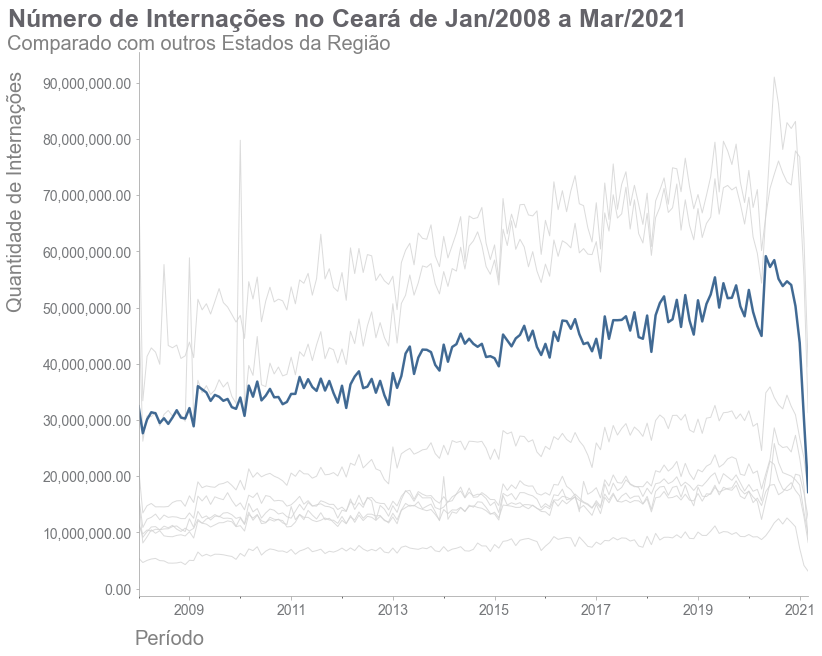

In [104]:
plt.figure(figsize = (12, 10))

for estado in valor_total_nordeste.index.tolist():
    ax = valor_total_nordeste.loc[estado].T.plot(color = 'lightgrey', linewidth = 1, alpha = 0.8)

ax = valor_total_nordeste.loc['Ceará'].T.plot(color = BLUE1, linewidth = 2.5, alpha = 0.8)

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
ax.set_yticks(range(0, 90000001, 10000000))
ax.tick_params(color = 'darkgrey')
ax.spines['bottom'].set_color('darkgrey')
ax.spines['left'].set_color('darkgrey')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(14)
    i.set_color(GRAY5)


plt.text(425, 100000000, '$\\bf{Número\ de\ Internações\ no\ Ceará\ de\ Jan/2008\ a\ Mar/2021}$',
         fontsize = 25, color = GRAY4)
plt.text(425, 96000000, 'Comparado com outros Estados da Região',
         fontsize = 20, color = GRAY6)

plt.text(425, 50000000, 'Quantidade de Internações', fontsize = 20, rotation = 'vertical', color = GRAY6)
plt.text(455, -10000000, 'Período', fontsize = 20, color = GRAY6)

plt.show()

Com esse último gráfico podemos comparar o total de gastos do Estado do Ceará em relação a todos os outros.

## 7.3 Conclusões

- O Ceará é o 10º Estado do Brasil com maior número de gastos de Janeiro de 2008 a Março de 2021;
- O valor total do Ceará corresponde a 3.88% do total do Brasil, ou seja, R$  6.573.100.152,04 bilhões no período analisado;
- A Região Nordeste possui 23.46% do valor total gasto no país no período analisado;
- O Ceará é o 3º estado do Nordeste com maior número de gastos durante o período;
- O Estado do Ceará possui 16.55% dos gastos totais da Região Nordeste no período analisado.

# 8 Total de Gastos por Município do Ceará

Finalmente, analisaremos os gastos por municípos no Ceará, analogamente ao que fizemos anteriormente.

## 8.1 Carregamento & Limpeza dos Dados

In [105]:
valor_total_municipios_ceara = pd.read_csv('../data/valor_total_municipios_ceara.csv', sep = ';', encoding = 'ISO-8859-1', skiprows = 3,
                            skipfooter = 13, thousands = '.', decimal = ',', engine = 'python')

In [106]:
valor_total_municipios_ceara.head(3)

,Município,2000/Fev,2000/Nov,2003/Jan,2005/Fev,2007/Jan,2007/Fev,2007/Jul,2007/Ago,2007/Set,...,2020/Jul,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar,Total
0,230020 Acaraú,-,-,-,-,-,-,-,-,-,...,113231.06,93183.73,118485.86,113438.04,141733.72,145688.14,146227.62,-,-,20554520.01
1,230030 Acopiara,-,-,-,-,-,-,-,1255.82,-,...,66296.71,165171.05,106387.44,150184.86,95017.32,45760.22,51506.59,73818.81,105397.22,12065906.74
2,230040 Aiuaba,-,-,-,-,-,-,-,-,-,...,9636.92,7718.71,8824.78,10461.70,5503.62,2556.26,-,-,-,708463.16


Data cleaning time!

In [107]:
# cópia do dataframe original
valor_total_muni_ce = valor_total_municipios_ceara.copy()

# remover os 6 números iniciais dos nomes dos municípios
valor_total_muni_ce['Município'] = valor_total_muni_ce['Município'].str[7:]

# coloca a coluna Município como índice
valor_total_muni_ce = valor_total_muni_ce.set_index('Município').rename_axis(None)

valor_total_muni_ce.head(3)

,2000/Fev,2000/Nov,2003/Jan,2005/Fev,2007/Jan,2007/Fev,2007/Jul,2007/Ago,2007/Set,2007/Out,...,2020/Jul,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar,Total
Acaraú,-,-,-,-,-,-,-,-,-,-,...,113231.06,93183.73,118485.86,113438.04,141733.72,145688.14,146227.62,-,-,20554520.01
Acopiara,-,-,-,-,-,-,-,1255.82,-,1201.60,...,66296.71,165171.05,106387.44,150184.86,95017.32,45760.22,51506.59,73818.81,105397.22,12065906.74
Aiuaba,-,-,-,-,-,-,-,-,-,-,...,9636.92,7718.71,8824.78,10461.70,5503.62,2556.26,-,-,-,708463.16


In [108]:
# encontrar a posição da coluna '2008/Jan'
valor_total_muni_ce.columns.get_loc('2008/Jan')

12

In [109]:
# excluir as colunas anteriores a '2008/Jan'
valor_total_muni_ce = valor_total_muni_ce[valor_total_muni_ce.columns[12:]]
valor_total_muni_ce.head(3)

,2008/Jan,2008/Fev,2008/Mar,2008/Abr,2008/Mai,2008/Jun,2008/Jul,2008/Ago,2008/Set,2008/Out,...,2020/Jul,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar,Total
Acaraú,82676.41,114891.09,116394.76,118194.80,112024.71,108310.19,110200.86,79847.91,102307.11,84578.63,...,113231.06,93183.73,118485.86,113438.04,141733.72,145688.14,146227.62,-,-,20554520.01
Acopiara,136153.05,152981.70,138762.43,122212.06,115588.03,113925.41,100111.73,115570.95,94984.25,96643.75,...,66296.71,165171.05,106387.44,150184.86,95017.32,45760.22,51506.59,73818.81,105397.22,12065906.74
Aiuaba,6830.40,3434.60,5143.67,2308.77,3198.82,2500.16,4901.68,5543.37,5794.86,4183.12,...,9636.92,7718.71,8824.78,10461.70,5503.62,2556.26,-,-,-,708463.16


In [110]:
valor_total_muni_ce.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172 entries, Acaraú to Viçosa do Ceará
Columns: 160 entries, 2008/Jan to Total
dtypes: float64(1), object(159)
memory usage: 216.3+ KB


In [111]:
valor_total_muni_ce = valor_total_muni_ce.replace('-', 0)

In [112]:
valor_total_muni_ce.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172 entries, Acaraú to Viçosa do Ceará
Columns: 160 entries, 2008/Jan to Total
dtypes: float64(1), object(159)
memory usage: 216.3+ KB


In [113]:
valor_total_muni_ce = valor_total_muni_ce.apply(pd.to_numeric, errors = 'coerce')

In [114]:
valor_total_muni_ce.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172 entries, Acaraú to Viçosa do Ceará
Columns: 160 entries, 2008/Jan to Total
dtypes: float64(160)
memory usage: 216.3+ KB


In [115]:
valor_total_muni_ce.columns

Index(['2008/Jan', '2008/Fev', '2008/Mar', '2008/Abr', '2008/Mai', '2008/Jun',
       '2008/Jul', '2008/Ago', '2008/Set', '2008/Out',
       ...
       '2020/Jul', '2020/Ago', '2020/Set', '2020/Out', '2020/Nov', '2020/Dez',
       '2021/Jan', '2021/Fev', '2021/Mar', 'Total'],
      dtype='object', length=160)

In [116]:
# elimina a coluna 'Total'
valor_total_muni_ce = valor_total_muni_ce.drop('Total', axis = 1)

In [117]:
# muda as datas que estão em string pro tipo data
valor_total_muni_ce.columns = pd.to_datetime(valor_total_muni_ce.columns, format = '%Y/%b')

In [118]:
valor_total_muni_ce.head(3)

,2008-01-01,2008-02-01,2008-03-01,2008-04-01,2008-05-01,2008-06-01,2008-07-01,2008-08-01,2008-09-01,2008-10-01,...,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,2021-01-01,2021-02-01,2021-03-01
Acaraú,82676.41,114891.09,116394.76,118194.80,112024.71,108310.19,110200.86,79847.91,102307.11,84578.63,...,103584.53,113231.06,93183.73,118485.86,113438.04,141733.72,145688.14,146227.62,0.00,0.00
Acopiara,136153.05,152981.70,138762.43,122212.06,115588.03,113925.41,100111.73,115570.95,94984.25,96643.75,...,64524.55,66296.71,165171.05,106387.44,150184.86,95017.32,45760.22,51506.59,73818.81,105397.22
Aiuaba,6830.40,3434.60,5143.67,2308.77,3198.82,2500.16,4901.68,5543.37,5794.86,4183.12,...,11732.13,9636.92,7718.71,8824.78,10461.70,5503.62,2556.26,0.00,0.00,0.00


In [119]:
valor_total_muni_ce = valor_total_muni_ce.T

In [120]:
valor_total_muni_ce['Soma'] = valor_total_muni_ce.drop(['Fortaleza'], axis = 1).sum(axis = 1)

In [121]:
valor_total_muni_ce = valor_total_muni_ce[['Fortaleza', 'Soma']]

In [122]:
valor_total_muni_ce

,Fortaleza,Soma
2008-01-01,20527233.15,11917095.39
2008-02-01,15078526.16,12564778.70
2008-03-01,16837904.72,13247465.50
2008-04-01,17476762.38,13899458.62
2008-05-01,17842547.73,13347356.89
...,...,...
2020-11-01,32892301.77,21133986.65
2020-12-01,32317946.53,17953605.80
2021-01-01,27605071.53,16138354.21
2021-02-01,16454937.19,13732013.81


## 8.2 Análise Gráfica

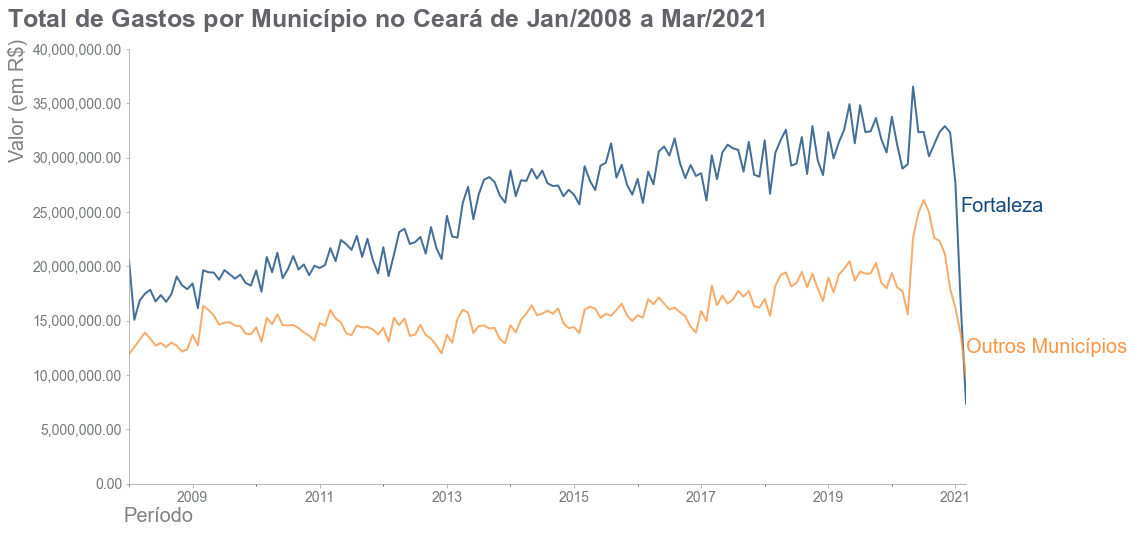

In [123]:
color = [BLUE1, ORANGE1]

ax = valor_total_muni_ce.plot(alpha = 0.8, figsize = (15, 8), color = color, legend = None, linewidth = 2)

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
ax.set_yticks(range(0, 40000001, 5000000))
ax.tick_params(color = 'darkgrey')
ax.spines['bottom'].set_color('darkgrey')
ax.spines['left'].set_color('darkgrey')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(14)
    i.set_color(GRAY5)
    
   
plt.text(433, 42000000, '$\\bf{Total\ de\ Gastos\ por\ Município\ no\ Ceará\ de\ Jan/2008\ a\ Mar/2021}$',
         fontsize = 25, color = GRAY4)

plt.text(433, 30000000, 'Valor (em R$)', fontsize = 20, rotation = 'vertical', color = GRAY6)
plt.text(455, -3500000, 'Período', fontsize = 20, color = GRAY6)

plt.text(613, 25000000, 'Fortaleza', fontsize = 20, color = BLUE1)
plt.text(614, 12000000, 'Outros Municípios', fontsize = 20, color = ORANGE1)

plt.show()

In [124]:
valor_total_muni_ce = valor_total_muni_ce.T

In [125]:
valor_total_muni_ce['Soma'] = valor_total_muni_ce.sum(axis = 1)

In [126]:
valor_total_muni_ce['Porcentagem'] = (valor_total_muni_ce['Soma'] / valor_total_muni_ce['Soma'].sum()) * 100

In [127]:
print('O valor total gasto por Fortaleza corresponde a {:.2f}% do total do Estado do Ceará,\
        \ncontra todos os outros 183 municípios correspondendo a {:.2f}% do total.'.format(valor_total_muni_ce['Porcentagem']['Fortaleza'],
                                                                                          valor_total_muni_ce['Porcentagem']['Soma']))

O valor total gasto por Fortaleza corresponde a 61.77% do total do Estado do Ceará,        
contra todos os outros 183 municípios correspondendo a 38.23% do total.


## 8.3 Conclusões

Considerando o total gasto por município no Estado do Ceará, durante o período analisado, temos que:
- O valor total gasto por Fortaleza corresponde a 61,77% do total do Estado do Ceará e        
- Todos os outros 183 municípios correspondem a 38,23% do total.

Ou seja, Fortaleza tem menos internações (41,62%) que todos os outros 183 municípios juntos, mas mais investimentos e gastos com as mesmas (61,77%).

# 9 Valor Médio por Internação - Brasil

Já analisamos a quantidade de internações e o valor total das mesmas. Um próximo passo lógico então seria então analisar o valor médio de cada internação.

## 9.1 Carregamento & Limpeza dos Dados

In [128]:
# importar o aquivo do valor médio das internações no Brasil
valor_medio_br_raw = pd.read_csv('../data/valor_medio_internacao_brasil.csv', sep = ';', encoding = 'ISO-8859-1', skiprows = 3,
                            skipfooter = 12, thousands = '.', decimal = ',', engine = 'python')

In [129]:
valor_medio_br_raw.head(3)

,Unidade da Federação,2007/Jan,2007/Fev,2007/Mar,2007/Abr,2007/Mai,2007/Jun,2007/Jul,2007/Ago,2007/Set,...,2020/Jul,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar,Total
0,11 Rondônia,NaN,604.33,NaN,NaN,NaN,NaN,NaN,601.34,390.41,...,1251.19,1292.21,1059.42,929.05,988.04,1076.70,1165.31,1263.74,2247.12,718.32
1,12 Acre,184.65,NaN,NaN,NaN,NaN,1099.17,NaN,2094.01,823.63,...,1142.04,1023.58,931.90,822.53,885.23,971.38,837.67,784.24,636.10,706.44
2,13 Amazonas,378.28,475.94,NaN,531.94,NaN,NaN,212.75,605.98,660.44,...,1252.11,1189.59,1184.50,1185.63,1325.96,1328.94,1495.29,1269.31,1086.81,852.58


In [130]:
valor_medio_br_raw.tail(3)

,Unidade da Federação,2007/Jan,2007/Fev,2007/Mar,2007/Abr,2007/Mai,2007/Jun,2007/Jul,2007/Ago,2007/Set,...,2020/Jul,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar,Total
24,51 Mato Grosso,1011.56,116.78,NaN,NaN,NaN,1891.44,762.30,623.16,726.39,...,1513.36,1503.82,1415.18,1399.50,1313.40,1425.22,1301.76,1296.30,1301.88,900.37
25,52 Goiás,287.38,433.27,NaN,NaN,NaN,10772.32,1096.22,602.00,514.84,...,1793.53,1841.09,1824.08,1690.98,1598.19,1583.36,1590.01,1748.93,2005.40,1097.37
26,53 Distrito Federal,661.97,428.43,457.97,NaN,554.69,554.69,11628.24,4084.07,2740.09,...,1560.95,1348.51,1236.12,1255.10,1198.18,1290.68,1290.08,1279.56,1317.82,1013.02


Vamos melhorar esse dataframe.

In [131]:
print('A posição da coluna \'2008/Jan\' é a {}.'.format(valor_medio_br_raw.columns.get_loc('2008/Jan')))

A posição da coluna '2008/Jan' é a 13.


In [132]:
# cópia do df original
valor_medio_br = valor_medio_br_raw.copy()

# UF como indíce
valor_medio_br = valor_medio_br.set_index('Unidade da Federação').rename_axis(None)

# removendo as colunas (até a 12, pois tiramos uma coluna, a da UF)
valor_medio_br = valor_medio_br.drop(valor_medio_br.columns[:12], axis = 1)

In [133]:
valor_medio_br.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27 entries, 11 Rondônia to 53 Distrito Federal
Columns: 160 entries, 2008/Jan to Total
dtypes: float64(160)
memory usage: 34.0+ KB


In [134]:
valor_medio_br.isna().sum().sum()

0

Todas as 160 colunas são do tipo ```float64``` e não há nenhum valor faltante.

In [135]:
# remover o número do nome dos Estado
valor_medio_br.index = valor_medio_br.index.str[3:]

Ainda temos uma coluna do 'Total', vamos removê-la.

In [136]:
valormediobr = valor_medio_br.copy()
valormediobr = valormediobr.sort_values(by = 'Total', ascending = False)
valormediobr = valormediobr.drop('Total', axis = 1)

# formatar a data
valormediobr.columns = pd.to_datetime(valormediobr.columns, format='%Y/%b')

## 9.2 Análise Gráfica

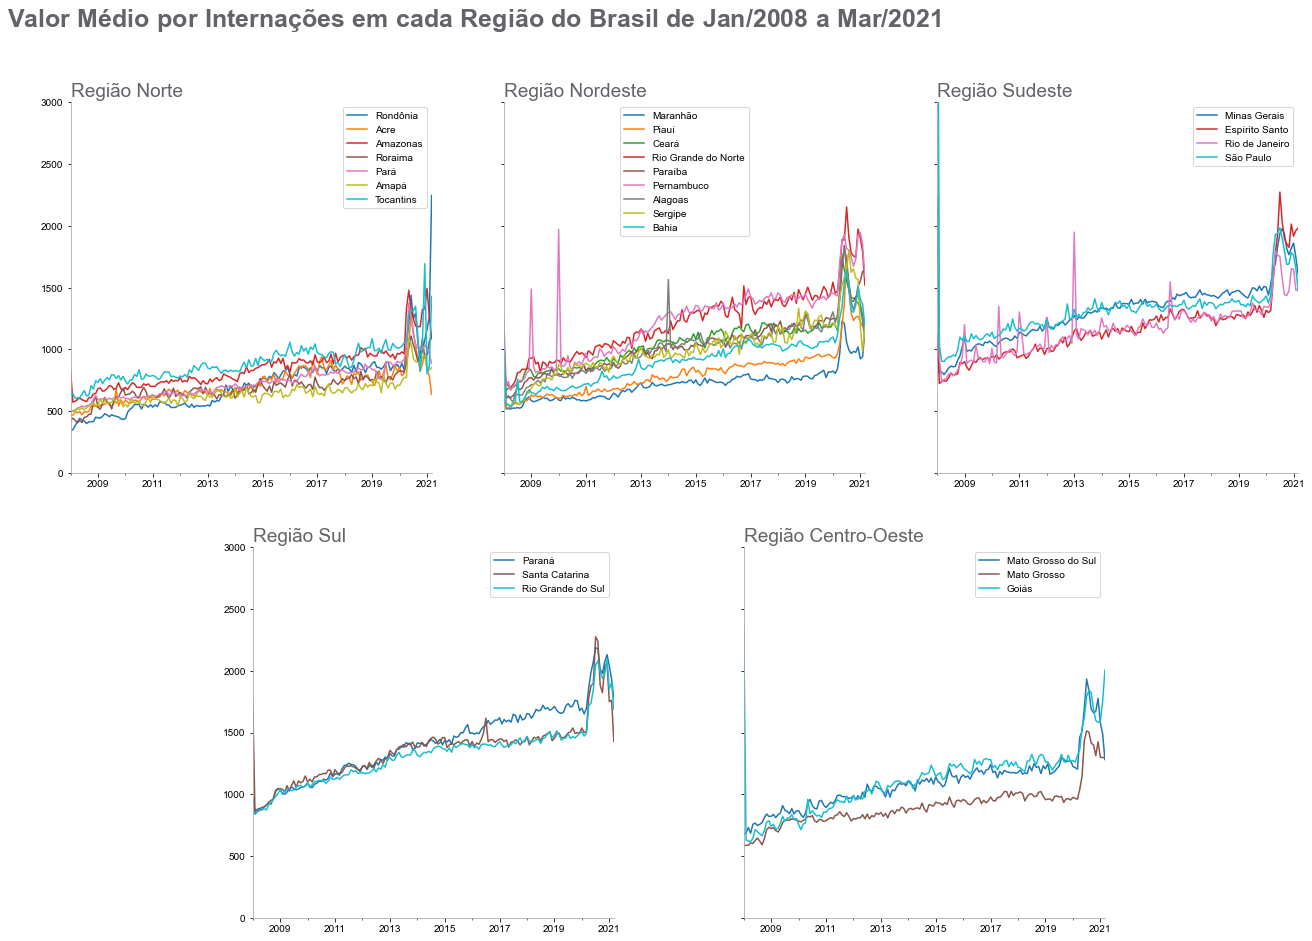

In [137]:
fig, axes = plt.subplots(2, 3, sharey = True, figsize = (22, 15))

fig.text(0.085, 0.95, '$\\bf{Valor\ Médio\ por\ Internações\ em\ cada\ Região\ do\ Brasil\ de\ Jan/2008\ a\ Mar/2021}$',
         fontsize = 25, color = GRAY4)

# foi necessário dar um limite para o eixo y pois os valores médios do sudeste
# possuem um pico muito elevado no início que estava deturpando a plotagem
plt.ylim(0, 3000)

axes[1, 2].set_visible(False)

valormediobr.loc[norte].T.plot(ax = axes[0, 0], colormap = 'tab10')
axes[0, 0].set_title('Região Norte', loc = 'left', fontsize = 19, color = GRAY4)
#axes[0, 0].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
axes[0, 0].spines['bottom'].set_color('darkgrey')
axes[0, 0].spines['left'].set_color('darkgrey')
axes[0, 0].spines['right'].set_visible(False)
axes[0, 0].spines['top'].set_visible(False)

valormediobr.loc[nordeste].T.plot(ax = axes[0, 1], colormap = 'tab10')
axes[0, 1].set_title('Região Nordeste', loc = 'left', fontsize = 19, color = GRAY4)
axes[0, 1].spines['bottom'].set_color('darkgrey')
axes[0, 1].spines['left'].set_color('darkgrey')
axes[0, 1].spines['right'].set_visible(False)
axes[0, 1].spines['top'].set_visible(False)

valormediobr.loc[sudeste].T.plot(ax = axes[0, 2], colormap = 'tab10')
axes[0, 2].set_title('Região Sudeste', loc = 'left', fontsize = 19, color = GRAY4)
axes[0, 2].spines['bottom'].set_color('darkgrey')
axes[0, 2].spines['left'].set_color('darkgrey')
axes[0, 2].spines['right'].set_visible(False)
axes[0, 2].spines['top'].set_visible(False)

valormediobr.loc[sul].T.plot(ax = axes[1, 0], colormap = 'tab10')
axes[1, 0].set_title('Região Sul', loc = 'left', fontsize = 19, color = GRAY4)
axes[1, 0].spines['bottom'].set_color('darkgrey')
axes[1, 0].spines['left'].set_color('darkgrey')
axes[1, 0].spines['right'].set_visible(False)
axes[1, 0].spines['top'].set_visible(False)

valormediobr.loc[centro_oeste].T.plot(ax = axes[1, 1], colormap = 'tab10')
axes[1, 1].set_title('Região Centro-Oeste', loc = 'left', fontsize = 19, color = GRAY4)
axes[1, 1].spines['bottom'].set_color('darkgrey')
axes[1, 1].spines['left'].set_color('darkgrey')
axes[1, 1].spines['right'].set_visible(False)
axes[1, 1].spines['top'].set_visible(False)

axes[1, 0].set_position([0.24, 0.125, 0.228, 0.343])
axes[1, 1].set_position([0.55, 0.125, 0.228, 0.343])

# plt.savefig('a.jpg')

plt.show()

No caso do valor médio por internação já temos algo mais parecido entre os Estados. Será que esse grande crescimento no valor médio após 2020 se deve à Covid-19? Não podemos afirmar isso, pois como já analisamos, o número de internações nesse período está menor que nos períodos anteriores, pois os dados ainda não estão computados completamente.

**Em relação ao valor médio por internação, qual a posição do Ceará no Brasil?**

In [138]:
# o dataset "valormediobr" já está ordenado pelo valor total (somamos 1 pois a contagem se inicia no 0)
print('A posição do Ceará em valor médio por internação no Brasil é: {}.'.format(valormediobr.index.get_loc('Ceará') + 1))

A posição do Ceará em valor médio por internação no Brasil é: 12.


Aqui não faz muito sentido analisarmos por posição levando em consideração o valor total somado de todos os meses do período, por se tratar de uma média.

In [139]:
valormediobr2 = valormediobr.copy()
valormediobr2 = valormediobr2.T

In [140]:
valormediobr2['Nordeste'] = (valormediobr2[nordeste].sum(axis = 1)) / len(nordeste)
valormediobr2['Norte'] = (valormediobr2[norte].sum(axis = 1)) / len(norte)
valormediobr2['Sudeste'] = (valormediobr2[sudeste].sum(axis = 1)) / len(sudeste)
valormediobr2['Sul'] = (valormediobr2[sul].sum(axis = 1)) / len(sul)
valormediobr2['Centro_Oeste'] = (valormediobr2[centro_oeste].sum(axis = 1)) / len(centro_oeste)

valormediobr2 = valormediobr2[['Nordeste', 'Norte', 'Sudeste', 'Sul', 'Centro_Oeste']]

valormediobr2.head()

,Nordeste,Norte,Sudeste,Sul,Centro_Oeste
2008-01-01,900.51,525.89,3393.75,1201.46,1215.47
2008-02-01,612.24,498.14,873.82,849.28,634.62
2008-03-01,613.53,499.78,799.61,868.07,646.99
2008-04-01,597.94,508.40,801.36,878.74,636.62
2008-05-01,613.59,518.99,813.08,881.06,667.80


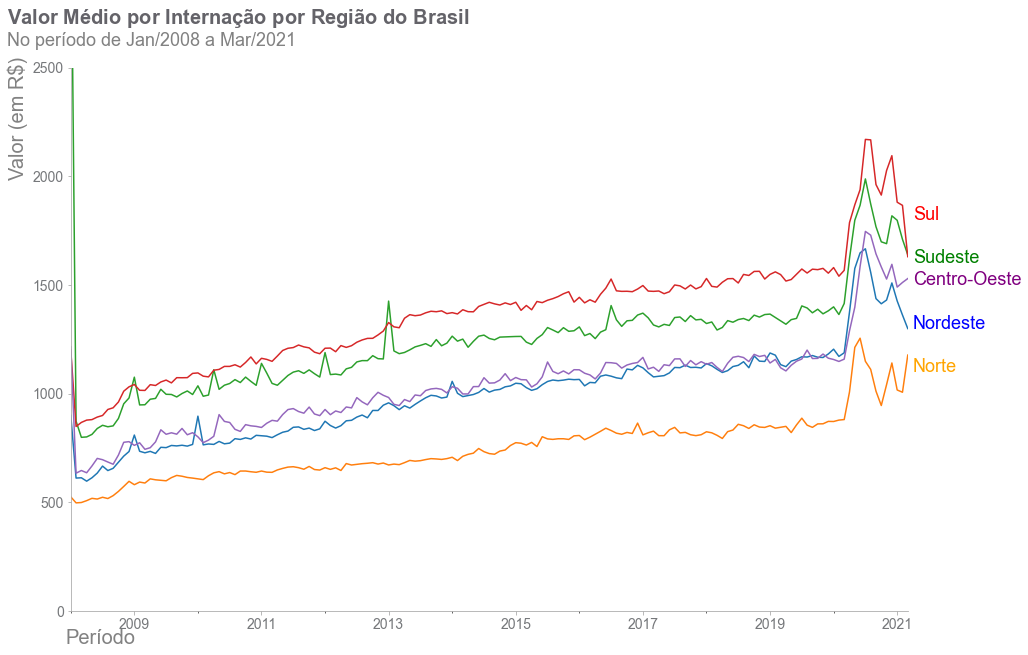

In [141]:
ax = valormediobr2.plot(figsize = (15, 10))

plt.ylim(0, 2500)

ax.tick_params(color = 'darkgrey', bottom = 'off')
ax.spines['bottom'].set_color('darkgrey')
ax.spines['left'].set_color('darkgrey')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(14)
    i.set_color(GRAY5)

plt.text(444, 2700, '$\\bf{Valor\ Médio\ por\ Internação\ por\ Região\ do\ Brasil}$',
         fontsize = 20, color = GRAY4)
plt.text(444, 2600, 'No período de Jan/2008 a Mar/2021',
         fontsize = 18, color = GRAY6)

plt.text(444, 2000, 'Valor (em R$)', fontsize = 20, rotation = 'vertical', color = GRAY6)
plt.text(455, -150, 'Período', fontsize = 20, color = GRAY6)

plt.text(615, 1600, 'Sudeste', fontsize = 18, color = 'green')
plt.text(615, 1300, 'Nordeste', fontsize = 18, color = 'blue')
plt.text(615, 1800, 'Sul', fontsize = 18, color = 'red')
plt.text(615, 1100, 'Norte', fontsize = 18, color = 'orange')
plt.text(615, 1500, 'Centro-Oeste', fontsize = 18, color = 'purple')

ax.get_legend().remove()

plt.show()

Por valor médio de internações, temos o Nordeste em quarto lugar.

In [142]:
valormedione = valormediobr.loc[nordeste]

In [143]:
valormedione['Soma'] = valormedione.sum(axis = 1)
valormedione = valormedione.sort_values(by = 'Soma', ascending = False)
valormedione = valormedione.drop('Soma', axis = 1)

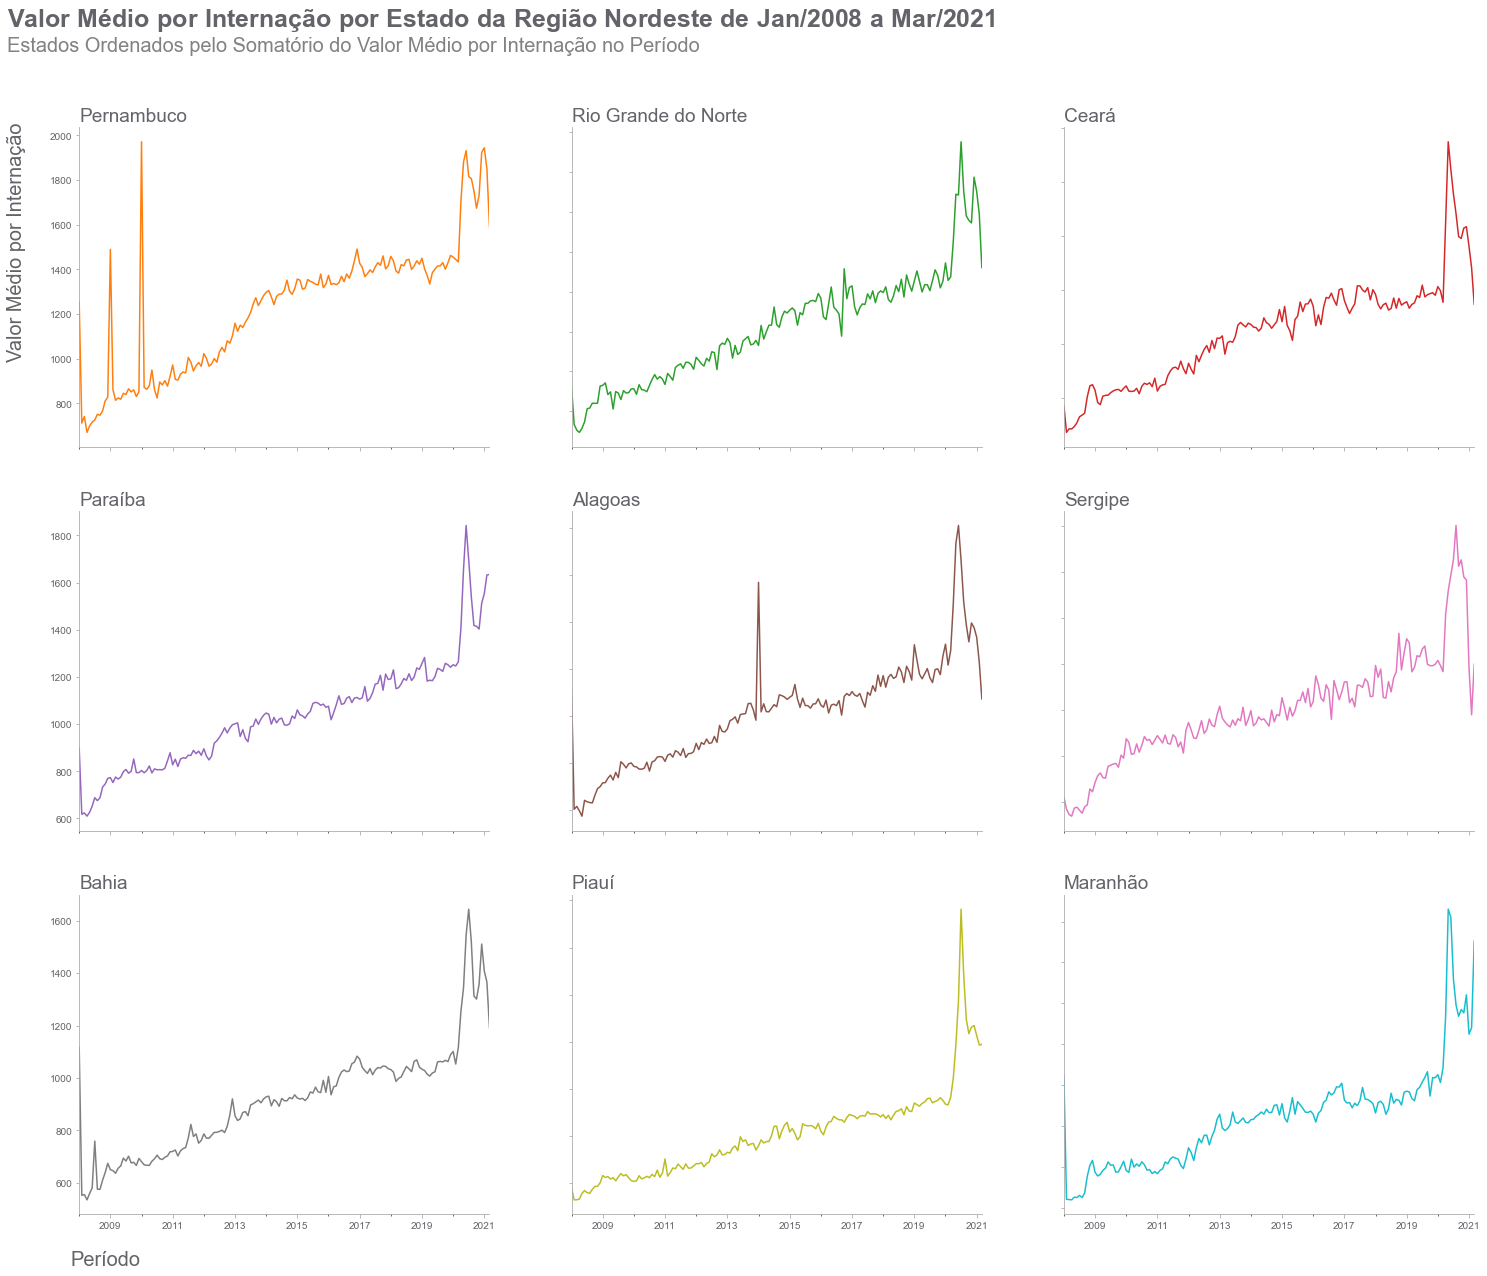

In [144]:
fig, axes = plt.subplots(3, 3, sharex = True, sharey = True, figsize = (25, 20))

palette = plt.get_cmap('tab10')

fig.text(0.085, 0.95, '$\\bf{Valor\ Médio\ por\ Internação\ por\ Estado\ da\ Região\ Nordeste\ de\ Jan/2008\ a\ Mar/2021}$',
         fontsize = 25, color = GRAY4)
fig.text(0.085, 0.933, 'Estados Ordenados pelo Somatório do Valor Médio por Internação no Período',
         fontsize = 20, color = GRAY6)

fig.text(0.085, 0.72, 'Valor Médio por Internação', fontsize = 20, rotation = 'vertical', color = GRAY4)
fig.text(0.12, 0.09, 'Período', fontsize = 20, color = GRAY4)

num = 0

for estado in valormedione.index.tolist():
    num += 1
    plt.subplot(3, 3, num)
    ax = valormedione.loc[estado].T.plot(color = palette(num))
    if num in range(7) :
        plt.tick_params(labelbottom = False)
    if num not in [1,4,7] :
        plt.tick_params(labelleft = False)
    plt.title(estado, loc = 'left', fontsize = 19, color = GRAY4)
    
    for i in ax.get_yticklabels() + ax.get_xticklabels():
        i.set_fontsize(10)
        i.set_color(GRAY4)
    
    ax.tick_params(color = 'darkgrey')
    ax.spines['bottom'].set_color('darkgrey')
    ax.spines['left'].set_color('darkgrey')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
plt.show()

É imediato ver que o valor médio por internação de cada Estado da Região Nordeste são bem parecidos, com alguns picos específicos.

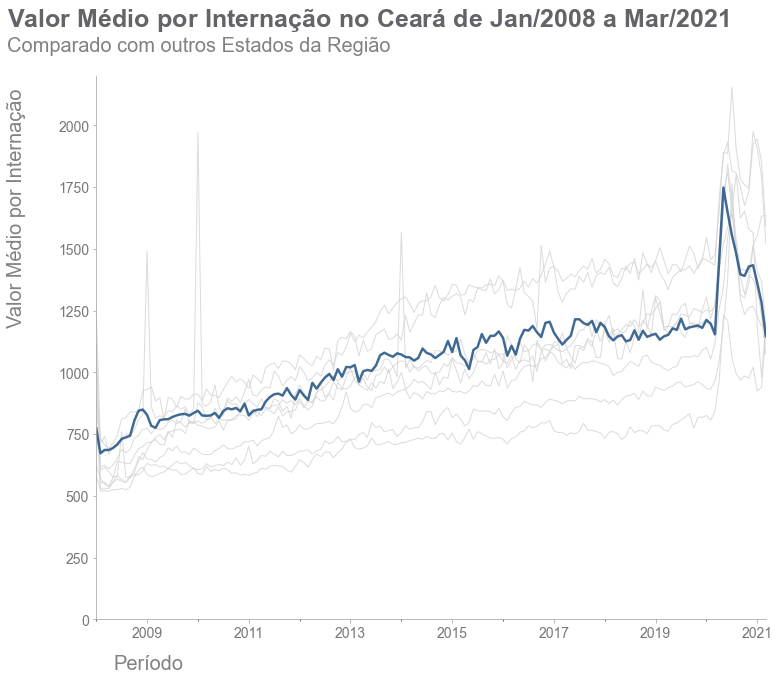

In [145]:
plt.figure(figsize = (12, 10))

for estado in valormedione.index.tolist():
    ax = valormedione.loc[estado].T.plot(color = 'lightgrey', linewidth = 1, alpha = 0.8)

ax = valormedione.loc['Ceará'].T.plot(color = BLUE1, linewidth = 2.5, alpha = 0.8)

plt.ylim(0, 2200)
ax.tick_params(color = 'darkgrey')
ax.spines['bottom'].set_color('darkgrey')
ax.spines['left'].set_color('darkgrey')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(14)
    i.set_color(GRAY5)


plt.text(435, 2400, '$\\bf{Valor\ Médio\ por\ Internação\ no\ Ceará\ de\ Jan/2008\ a\ Mar/2021}$',
         fontsize = 25, color = GRAY4)
plt.text(435, 2300, 'Comparado com outros Estados da Região',
         fontsize = 20, color = GRAY6)

plt.text(435, 1200, 'Valor Médio por Internação', fontsize = 20, rotation = 'vertical', color = GRAY6)
plt.text(460, -200, 'Período', fontsize = 20, color = GRAY6)

plt.show()

## 9.3 Conclusões

O valor médio por internação é parecido entre as regiões do país, com o Ceará figurando em 12º lugar nesse quesito, e o Nordeste em quarto lugar entre as regiões.

Considerando apenas o Nordeste, o Ceará está em 3º lugar.

# 10 Valor Médio por Internação - Ceará

Nossa última análise será em comparar Fortaleza e os outros municípios do Ceará em relação ao valor médio por internação, de Janeiro de 2008 a Março de 2021.

## 10.1 Carregamento & Limpeza dos Dados

In [146]:
# importar o aquivo do valor médio das internações no Ceará
valor_medio_ce_raw = pd.read_csv('../data/valor_medio_internacao_municipio_ce.csv', sep = ';', encoding = 'ISO-8859-1', skiprows = 3,
                            skipfooter = 12, thousands = '.', decimal = ',', engine = 'python')

In [147]:
valor_medio_ce_raw.head()

,Município,2007/Jan,2007/Fev,2007/Jul,2007/Ago,2007/Set,2007/Out,2007/Nov,2007/Dez,2008/Jan,...,2020/Jul,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar,Total
0,230020 Acaraú,NaN,NaN,NaN,NaN,NaN,NaN,682.99,352.57,379.25,...,507.76,512.00,479.70,446.61,420.57,423.51,468.68,NaN,NaN,425.30
1,230030 Acopiara,NaN,NaN,NaN,627.91,NaN,600.80,450.92,502.92,413.84,...,669.66,754.21,669.10,679.57,642.01,594.29,531.00,659.10,966.95,482.31
2,230040 Aiuaba,NaN,NaN,NaN,NaN,NaN,NaN,403.09,426.16,426.90,...,419.00,593.75,551.55,653.86,366.91,511.25,NaN,NaN,NaN,408.81
3,230060 Altaneira,NaN,NaN,NaN,NaN,NaN,NaN,266.02,292.67,301.90,...,466.02,474.71,688.95,390.35,1148.21,NaN,NaN,NaN,NaN,364.21
4,230070 Alto Santo,NaN,NaN,NaN,NaN,581.36,293.68,586.69,320.47,328.90,...,874.07,668.00,720.98,578.63,297.23,549.41,756.41,606.42,963.97,379.08


In [148]:
valor_medio_ce = valor_medio_ce_raw.copy()

valor_medio_ce['Município'] = valor_medio_ce['Município'].str[7:]

valor_medio_ce = valor_medio_ce.set_index('Município').rename_axis(None)

In [149]:
valor_medio_ce.head(3)

,2007/Jan,2007/Fev,2007/Jul,2007/Ago,2007/Set,2007/Out,2007/Nov,2007/Dez,2008/Jan,2008/Fev,...,2020/Jul,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar,Total
Acaraú,NaN,NaN,NaN,NaN,NaN,NaN,682.99,352.57,379.25,379.18,...,507.76,512.00,479.70,446.61,420.57,423.51,468.68,NaN,NaN,425.30
Acopiara,NaN,NaN,NaN,627.91,NaN,600.80,450.92,502.92,413.84,404.71,...,669.66,754.21,669.10,679.57,642.01,594.29,531.00,659.10,966.95,482.31
Aiuaba,NaN,NaN,NaN,NaN,NaN,NaN,403.09,426.16,426.90,264.20,...,419.00,593.75,551.55,653.86,366.91,511.25,NaN,NaN,NaN,408.81


In [150]:
valor_medio_ce.columns.get_loc('2008/Jan')

8

In [151]:
# excluir as colunas anteriores a '2008/Jan'
valor_medio_ce = valor_medio_ce[valor_medio_ce.columns[8:]]
valor_medio_ce.head(3)

,2008/Jan,2008/Fev,2008/Mar,2008/Abr,2008/Mai,2008/Jun,2008/Jul,2008/Ago,2008/Set,2008/Out,...,2020/Jul,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar,Total
Acaraú,379.25,379.18,382.88,385.00,387.63,391.01,405.15,358.06,368.01,395.23,...,507.76,512.00,479.70,446.61,420.57,423.51,468.68,NaN,NaN,425.30
Acopiara,413.84,404.71,433.63,441.20,431.30,448.53,439.09,406.94,394.13,423.88,...,669.66,754.21,669.10,679.57,642.01,594.29,531.00,659.10,966.95,482.31
Aiuaba,426.90,264.20,342.91,288.60,399.85,357.17,377.05,426.41,413.92,418.31,...,419.00,593.75,551.55,653.86,366.91,511.25,NaN,NaN,NaN,408.81


In [152]:
valor_medio_ce.info()

<class 'pandas.core.frame.DataFrame'>
Index: 173 entries, Acaraú to 
Columns: 160 entries, 2008/Jan to Total
dtypes: float64(160)
memory usage: 217.6+ KB


In [153]:
valor_medio_ce.isna().sum().sum()

2529

Temos 2529 valores nulos nesses dados. Irei substituí-los pelo valor zero.

In [154]:
valor_medio_ce = valor_medio_ce.fillna(0)

In [155]:
valor_medio_ce.isna().sum().sum()

0

In [156]:
valor_medio_ce.columns[-1]

'Total'

Vamos remover essa coluna 'Total'.

In [157]:
valor_medio_ce = valor_medio_ce.drop('Total', axis = 1)

In [158]:
valor_medio_ce.columns = pd.to_datetime(valor_medio_ce.columns, format = '%Y/%b')

In [159]:
valor_medio_ce = valor_medio_ce.T

In [160]:
valor_medio_ce['Soma'] = (valor_medio_ce.drop('Fortaleza', axis = 1).sum(axis = 1))/183

In [161]:
valor_medio_ce = valor_medio_ce[['Fortaleza', 'Soma']]

In [162]:
valor_medio_ce

,Fortaleza,Soma
2008-01-01,1171.98,329.36
2008-02-01,959.19,333.72
2008-03-01,1014.39,336.91
2008-04-01,981.29,339.44
2008-05-01,972.29,352.10
...,...,...
2020-11-01,1974.33,464.15
2020-12-01,2006.83,436.96
2021-01-01,1904.72,433.46
2021-02-01,1654.93,548.38


Como não faz muito sentido somar as médias de cada município para comparar com Fortaleza, somamos as média e dividimos pela quantidade de municípios existente e esse será o valor utilizado para comparação.

## 10.2 Análise Gráfica

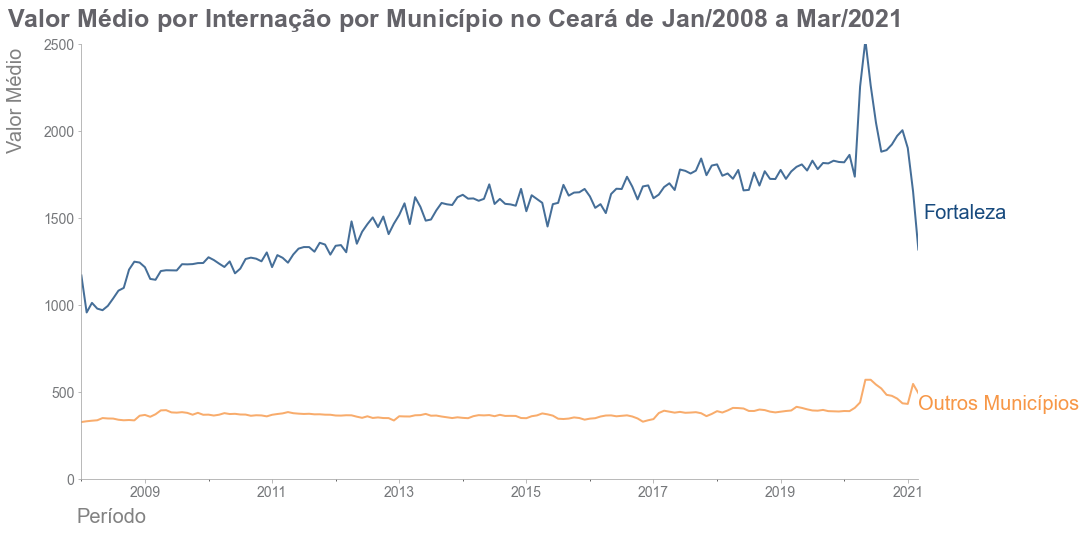

In [163]:
color = [BLUE1, ORANGE1]

ax = valor_medio_ce.plot(alpha = 0.8, figsize = (15, 8), color = color, legend = None, linewidth = 2)

plt.ylim(0, 2500)
ax.tick_params(color = 'darkgrey')
ax.spines['bottom'].set_color('darkgrey')
ax.spines['left'].set_color('darkgrey')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(14)
    i.set_color(GRAY5)
    

plt.text(442, 2600, '$\\bf{Valor\ Médio\ por\ Internação\ por\ Município\ no\ Ceará\ de\ Jan/2008\ a\ Mar/2021}$',
         fontsize = 25, color = GRAY4)

plt.text(442, 1900, 'Valor Médio', fontsize = 20, rotation = 'vertical', color = GRAY6)
plt.text(455, -250, 'Período', fontsize = 20, color = GRAY6)

plt.text(615, 1500, 'Fortaleza', fontsize = 20, color = BLUE1)
plt.text(614, 400, 'Outros Municípios', fontsize = 20, color = ORANGE1)

plt.show()

In [164]:
valor_medio_ce = valor_medio_ce.T
valor_medio_ce.shape[1]

159

In [165]:
valor_medio_ce['Média'] = valor_medio_ce.sum(axis = 1) / 159

In [166]:
valor_medio_ce

,2008-01-01 00:00:00,2008-02-01 00:00:00,2008-03-01 00:00:00,2008-04-01 00:00:00,2008-05-01 00:00:00,2008-06-01 00:00:00,2008-07-01 00:00:00,2008-08-01 00:00:00,2008-09-01 00:00:00,2008-10-01 00:00:00,...,2020-07-01 00:00:00,2020-08-01 00:00:00,2020-09-01 00:00:00,2020-10-01 00:00:00,2020-11-01 00:00:00,2020-12-01 00:00:00,2021-01-01 00:00:00,2021-02-01 00:00:00,2021-03-01 00:00:00,Média
Fortaleza,1171.98,959.19,1014.39,981.29,972.29,997.15,1039.67,1084.53,1100.39,1205.58,...,2049.83,1883.37,1892.39,1924.82,1974.33,2006.83,1904.72,1654.93,1321.04,1537.72
Soma,329.36,333.72,336.91,339.44,352.10,349.72,349.15,342.43,339.40,340.90,...,544.60,522.31,485.78,479.93,464.15,436.96,433.46,548.38,495.43,380.38


In [167]:
print('A média do valor gasto com internações em Fortaleza foi de {:,.2f} reais, \
      \ncontra {:.2f} reais dos outros municípios.'.format(valor_medio_ce['Média']['Fortaleza'],
                                                           valor_medio_ce['Média']['Soma']))

A média do valor gasto com internações em Fortaleza foi de 1,537.72 reais,       
contra 380.38 reais dos outros municípios.


## 10.3 Conclusões

Aqui fica evidente a disparidade entre o valor médio por internação em Fortaleza comparado com os outros 183 municípios do Estado do Ceará:
- A média do valor gasto com internações em Fortaleza foi de 1.537,72 reais e       
- A média do valor gasto com internações nos outros municípios foi de 380,38 reais.

# 11 Conclusão Final

Reunindo tudo que obtemos até aqui:


**Pelo número de internações no Brasil**
- O Ceará é o 9º Estado do Brasil com maior número de internações de Janeiro de 2008 a Março de 2021;
- A quantidade de internações no Ceará corresponde a 4,25% do total do Brasil, ou seja, 6322342 internações no período analisado;
- A Região Nordeste possui 27,29% das internações totais do país no período analisado;
- O Ceará é o 3º Estado da Região Nordeste em número de internações no período analisado;
- O Estado do Ceará possui 15,57% das internações totais da Região Nordeste no período analisado;
- Sobre a sazonalidade nos números de internações no Estado do Ceará: as altas ocorrem nos meses de Março a Junho, anualmente e os períodos de baixa ocorrem nos meses de Outubro a Janeiro anualmente, aproximadamente.

**Pelo número de internações no Ceará, considerando o local de internação**
- O número de internações de Fortaleza corresponde a 41,62% do total do Estado do Ceará e
- Todos os outros 183 municípios correspondem a 58,38% do total.

**Pelo número de internações no Ceará, considerando o local de residência**
- 29,12% de todas as internações do Ceará são de pessoas que residem em Fortaleza e
- 70,88% das internações são de pessoas que residem em qualquer um dos outros 183 municípios do Ceará.

Como isso se compara com a população total?
>Em 2018 foi estimado que Fortaleza possui 2,6 milhões de habitantes. Isso corresponde a 29,60% da população do Ceará, estimada em 9 milhões de habitantes. A soma de todos os habitantes de todos os outros municípios corresponde a 70,40% da população do Estado.

Com isso, vemos que os dados das internações por local de residência estão bastante coerentes com a população.
 
**Pelo Total de Gastos com Internação no Brasil**
- O Ceará é o 10º Estado do Brasil com maior número de gastos de Janeiro de 2008 a Março de 2021;
- O valor total do Ceará corresponde a 3,88% do total do Brasil, ou seja, R&#36; 6.573.100.152,04 bilhões no período analisado;
- A Região Nordeste possui 23,46% do valor total gasto no país no período analisado;
- O Ceará é o 3º estado do Nordeste com maior número de gastos durante o período;
- O Estado do Ceará possui 16,55% dos gastos totais da Região Nordeste no período analisado.
 
 
**Pelo total de gastos com internação por município no Estado do Ceará**
- O valor total gasto por Fortaleza corresponde a 61,77% do total do Estado do Ceará e
- Todos os outros 183 municípios correspondem a 38,23% do total.
Ou seja, Fortaleza tem menos internações (41,62%) que todos os outros 183 municípios juntos, mas mais investimentos e gastos com as mesmas (61,77%).
 
**Pelo valor médio por Internação no Brasil**

O valor médio por internação é parecido entre as regiões do país, com o Ceará figurando em 12º lugar nesse quesito, e o Nordeste em 4º lugar entre as regiões. Considerando apenas o Nordeste, o Ceará está em 3º lugar.
 
 
**Pelo valor médio por Internação por município no Estado do Ceará**

Aqui fica evidente a disparidade entre o valor médio por internação em Fortaleza comparado com os outros 183 municípios do Estado do Ceará:
- A média do valor gasto com internações em Fortaleza foi de R&#36; 1.537,72 e
- A média do valor gasto com internações nos outros municípios foi de R&#36; 380,38.

# 12 Referências

- [[1] Brazil's unified health system: the first 30 years and prospects for the future](https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(19)31243-7/fulltext#articleInformation)
- [[2] Constituição Federal de 1988](http://www.planalto.gov.br/ccivil_03/leis/l8080.htm)
- [[3] Os 6 maiores desafios que a saúde pública do Brasil vem enfrentando](https://www.ceen.com.br/os-6-maiores-desafios-que-a-saude-publica-do-brasil-vem-enfrentando/)
- [DATASUS](https://datasus.saude.gov.br/)
- [TABNET](http://www2.datasus.gov.br/DATASUS/index.php?area=02)
- [Notas Técnicas](Os 6 maiores desafios que a saúde pública do Brasil vem enfrentando)
- [Alura](https://www.alura.com.br/)
- [Bootcamp Data Science Aplicada](https://www.alura.com.br/bootcamp/data-science-aplicada/matriculas-abertas)
- [Storytelling with Data](https://www.storytellingwithdata.com/)
- [Storytelling with Data in Python](https://github.com/empathy87/storytelling-with-data#:~:text=storytelling%2Dwith%2Ddata%20(Python%20%2B%20matplotlib),-http%3A%2F%2Fwww&text=The%20book%20storytelling%20with%20data,pivotal%20point%20in%20your%20story.)
- [Numpy](https://numpy.org/](https://numpy.org/)
- [Pandas](https://pandas.pydata.org/](https://pandas.pydata.org/)
- [Matplotlib](https://matplotlib.org/](https://matplotlib.org/)
- Imagem do Banner por [Martha Dominguez de Gouveia](https://unsplash.com/@mdominguezfoto?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText) em [Unsplash](https://unsplash.com/?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText)